In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf

In [254]:
# 각 윈도우의 이전 결과와 다음 결과의 차이를 계산하여 반환
def windowed_test(series, test_func, window_size=10, min_periods=1):
    """
    Apply a test function using a sliding window approach,
    comparing previous and next windows.

    Parameters:
    series (array-like): The input time series
    test_func (function): The test function to apply to each window
    window_size (int): The size of the sliding window
    min_periods (int): Minimum number of observations in window required to have a value

    Returns:
    numpy.array: Array of absolute differences between test results of adjacent windows
    """
    half_window = window_size // 2

    # Convert to pandas Series for easy rolling window operations
    series = pd.Series(series)

    # Calculate results for previous and next windows
    prev_results = series.rolling(window=half_window, min_periods=min_periods).apply(
        test_func
    )
    next_results = (
        series.rolling(window=half_window, min_periods=min_periods)
        .apply(test_func)
        .shift(-half_window)
    )

    # Calculate absolute differences
    differences = np.abs(next_results - prev_results)

    # Remove NaN values from the beginning and end
    return differences.fillna(method="ffill").fillna(0).values



def mean_shift(series):
    """Detect shifts in the mean value."""
    return np.mean(series)


def std_deviation_change(series):
    """Detect changes in the standard deviation."""
    return np.std(series)


def slope_change(series):
    """Detect changes in the linear trend (slope)."""
    x = np.arange(len(series))
    slope, _, _, _, _ = stats.linregress(x, series)
    return slope


def plot_windowed_results(series, test_results, test_name, window_size):
    """Plot original series and test results."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot original series
    ax1.plot(series)
    ax1.set_title(
        f"Original Series and {test_name} Test Results (Window Size: {window_size})"
    )
    ax1.set_ylabel("Value")
    ax1.grid()

    # Plot test results
    ax2.plot(range(len(series)), test_results)
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Absolute Difference in Test Statistic")
    ax2.axhline(y=0, color="r", linestyle="--", label="No Change")
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

In [255]:
# 주식 데이터 다운로드
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# 주식 데이터 전처리
def preprocess_stock_data(stock_data):
    stock_data = stock_data['Close']
    return stock_data

In [256]:
# Detect change points
def detect_change_points(series, window_size=10, threshold=5.0, matrix=mean_shift):
    change_points = windowed_test(series, matrix, window_size)
    change_points_indices = np.where(change_points > threshold)[0]
    return change_points, change_points_indices

In [418]:
# Plot change points
def plot_change_points_original(stock_data, title, window_size=10, threshold=4.0, matrix=mean_shift):
    series = stock_data.values
    change_points, change_points_indices = detect_change_points(series, window_size, threshold, matrix)

    plt.figure(figsize=(40, 8))
    ax1 = plt.gca()  # Main axis for original series
    ax2 = ax1.twinx()  # Secondary axis for change points

    # Plot original series
    ax1.plot(series, label="Original Stock Data")
    ax1.scatter(change_points_indices, series[change_points_indices], color='red', label="Change Points", zorder=5)
    # Plot change points on the secondary axis
    ax2.plot(change_points, label="Statistical value", linestyle='--', color='purple')
    ax2.set_ylabel("Statistical value", fontsize=20) # (1) Increase label fontsize

    # Plot threshold line
    ax2.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

    # Set x-axis ticks to be evenly spaced
    num_ticks = len(series)
    x_ticks = np.linspace(0, len(series) - 1, num_ticks, dtype=int)
    ax1.set_xticks(x_ticks)
    # ax2.set_xticks(x_ticks)
    ax1.set_xticklabels(stock_data.index[x_ticks].strftime('%m-%d'), fontsize=8)  # (2) Increase tick label fontsize

    # Titles and labels
    ax1.set_title(title, fontsize=20)  # Increase title fontsize
    ax1.set_xlabel("Time", fontsize=20)  # Increase label fontsize
    ax1.set_ylabel("Data value", fontsize=20)  # Increase label fontsize

    # Increase tick label size
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='both', which='major', labelsize=18)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=15)  # Combine legends

    ax1.grid()
    # ax1.set_ylim(50,88)
    # ax2.set_ylim(0, 3.1) # change point 최대 ylim 설정.
    plt.show()


# (1) 11-Sep-01

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/2186366242.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


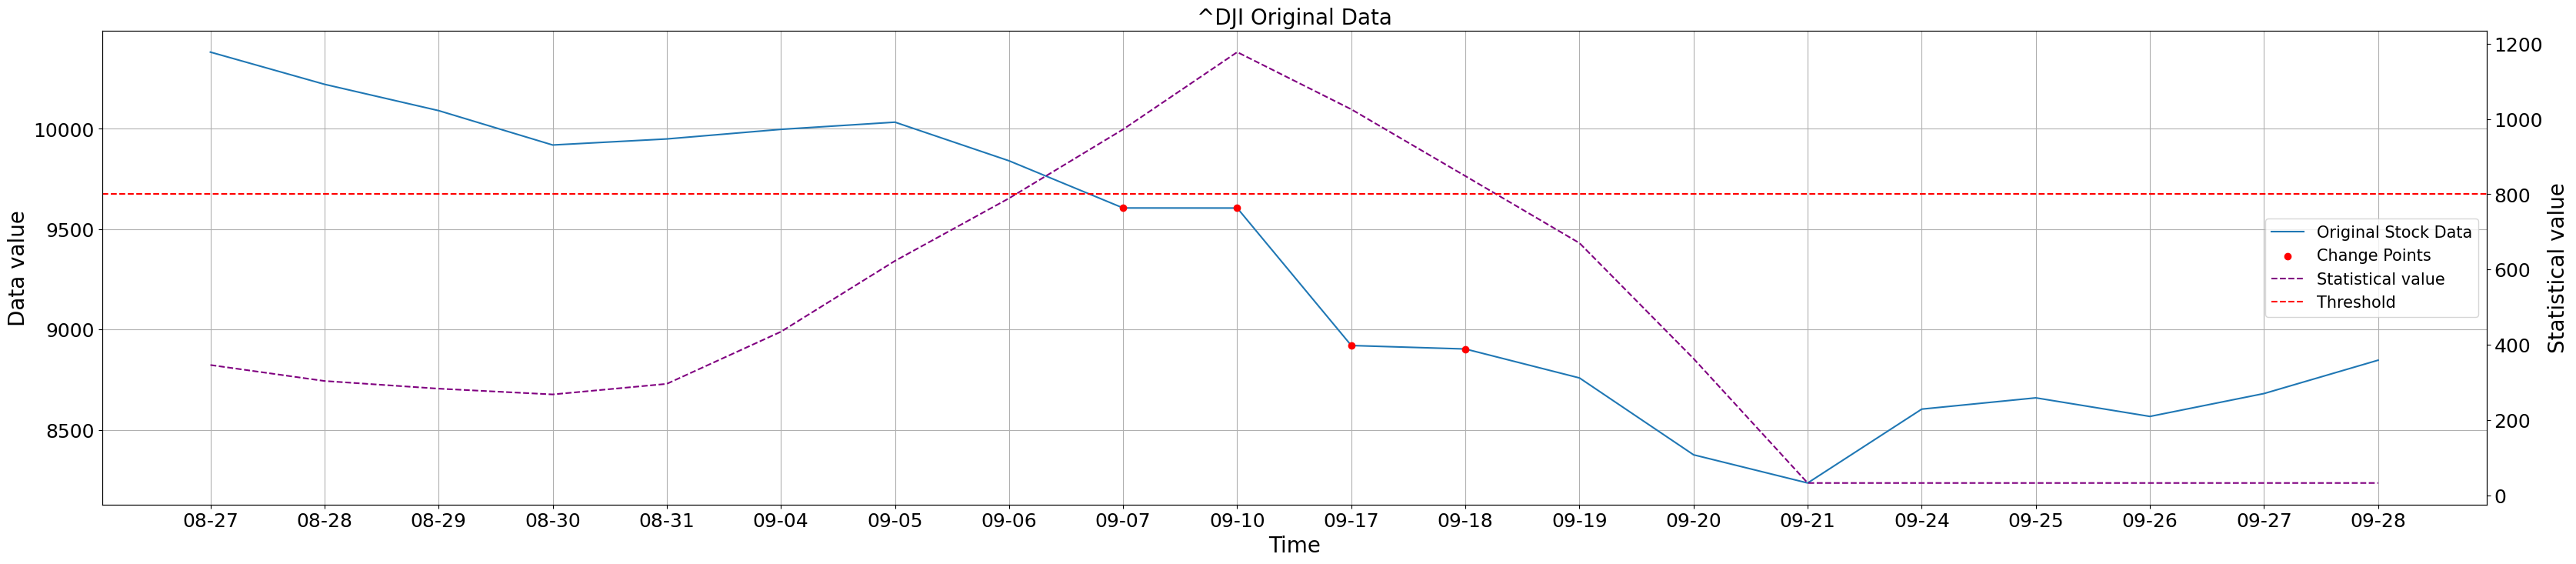

In [135]:
ticker = '^DJI' # Dow Jones Industrial Average (DJIA)
start_date = '2001-08-25'
end_date = '2001-10-01'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 10
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=800, window_size=window_size,  matrix=mean_shift)

# (2) 09-Oct-02

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/2186366242.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


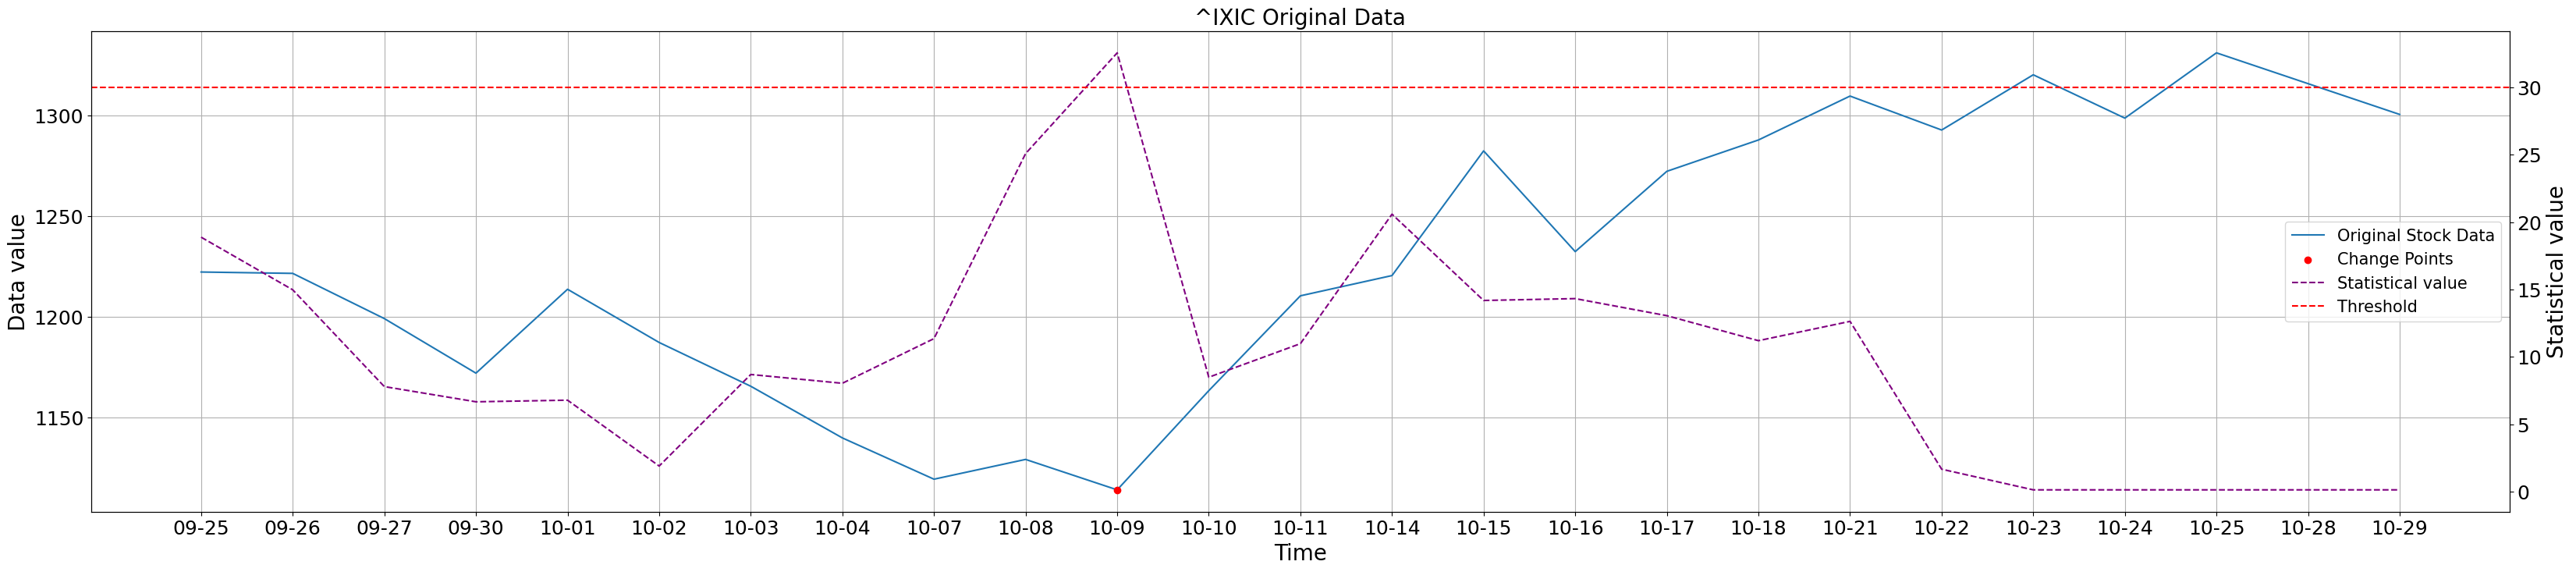

In [138]:
ticker = '^IXIC' # NASDAQ
start_date = '2002-09-25'
end_date = '2002-10-30'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 8
threshold = 30
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=std_deviation_change)

[*********************100%***********************]  1 of 1 completed


/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/2186366242.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


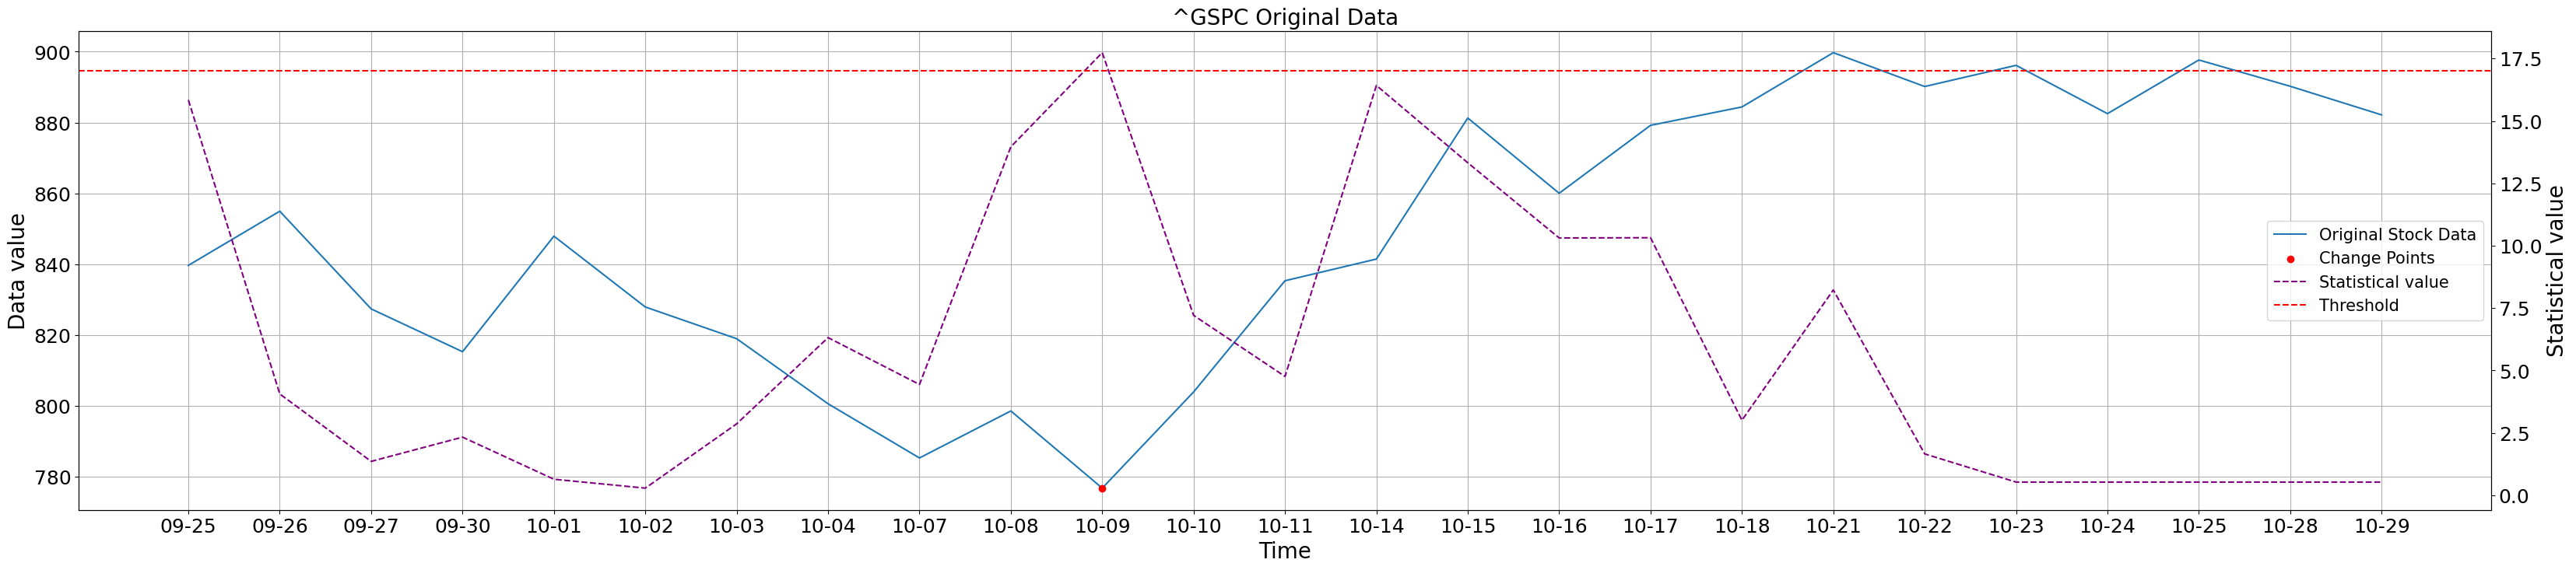

In [141]:
ticker = '^GSPC' # S&P 500
start_date = '2002-09-25'
end_date = '2002-10-30'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 8
threshold = 17
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=std_deviation_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/2186366242.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


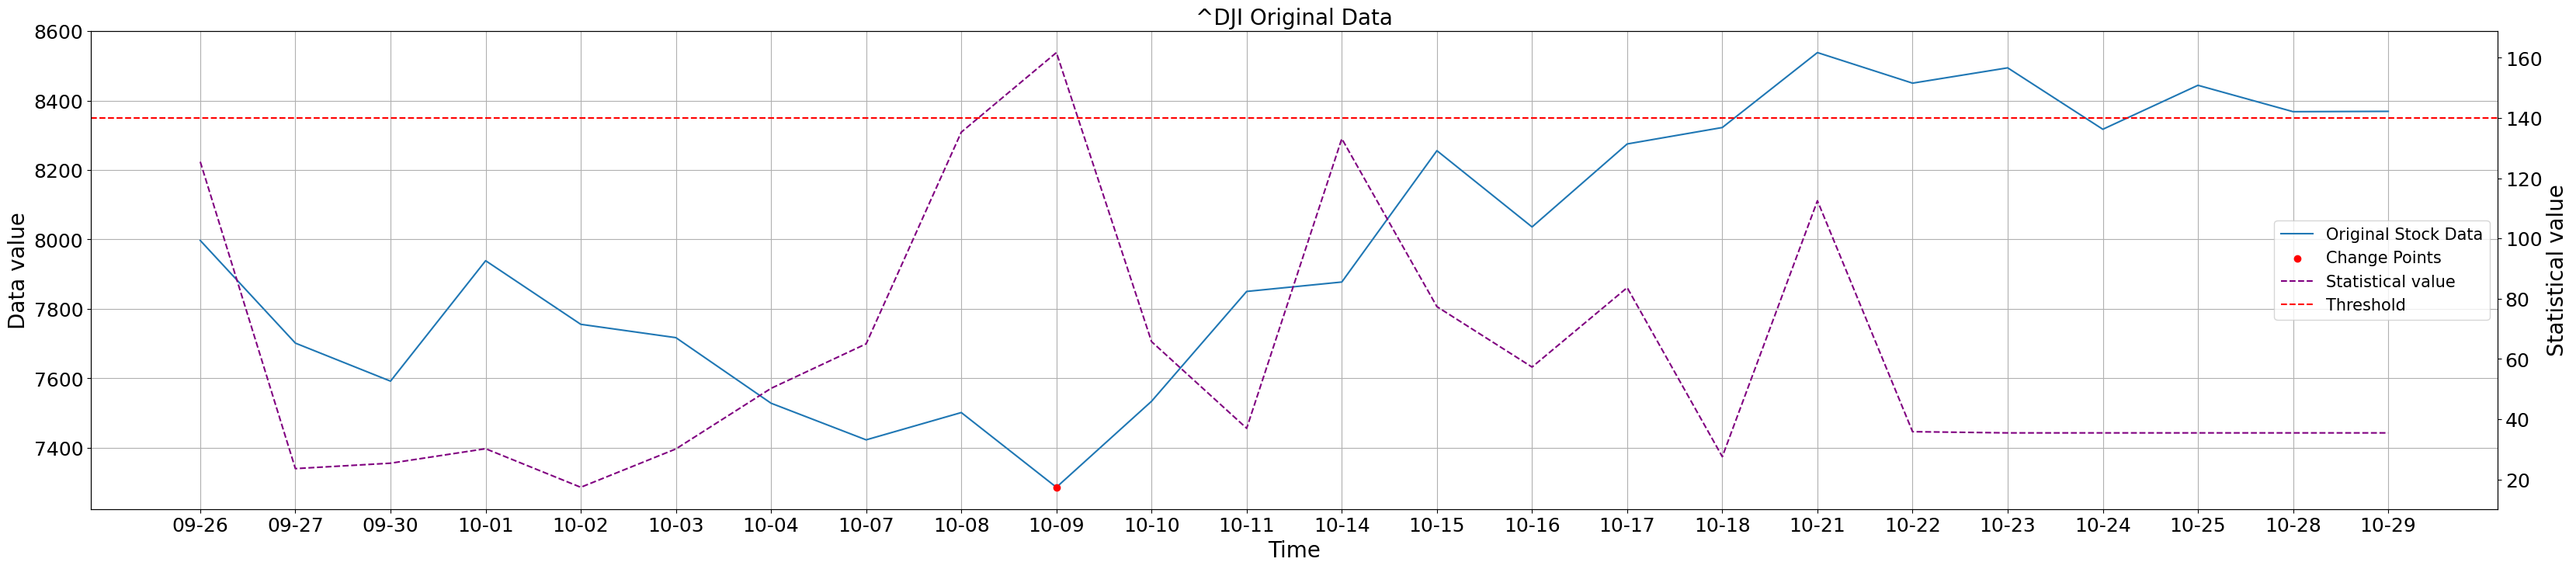

In [183]:
ticker = '^DJI' # Dow Jones Industrial Average
start_date = '2002-09-26'
end_date = '2002-10-30'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 8
threshold = 140
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=std_deviation_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/2186366242.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


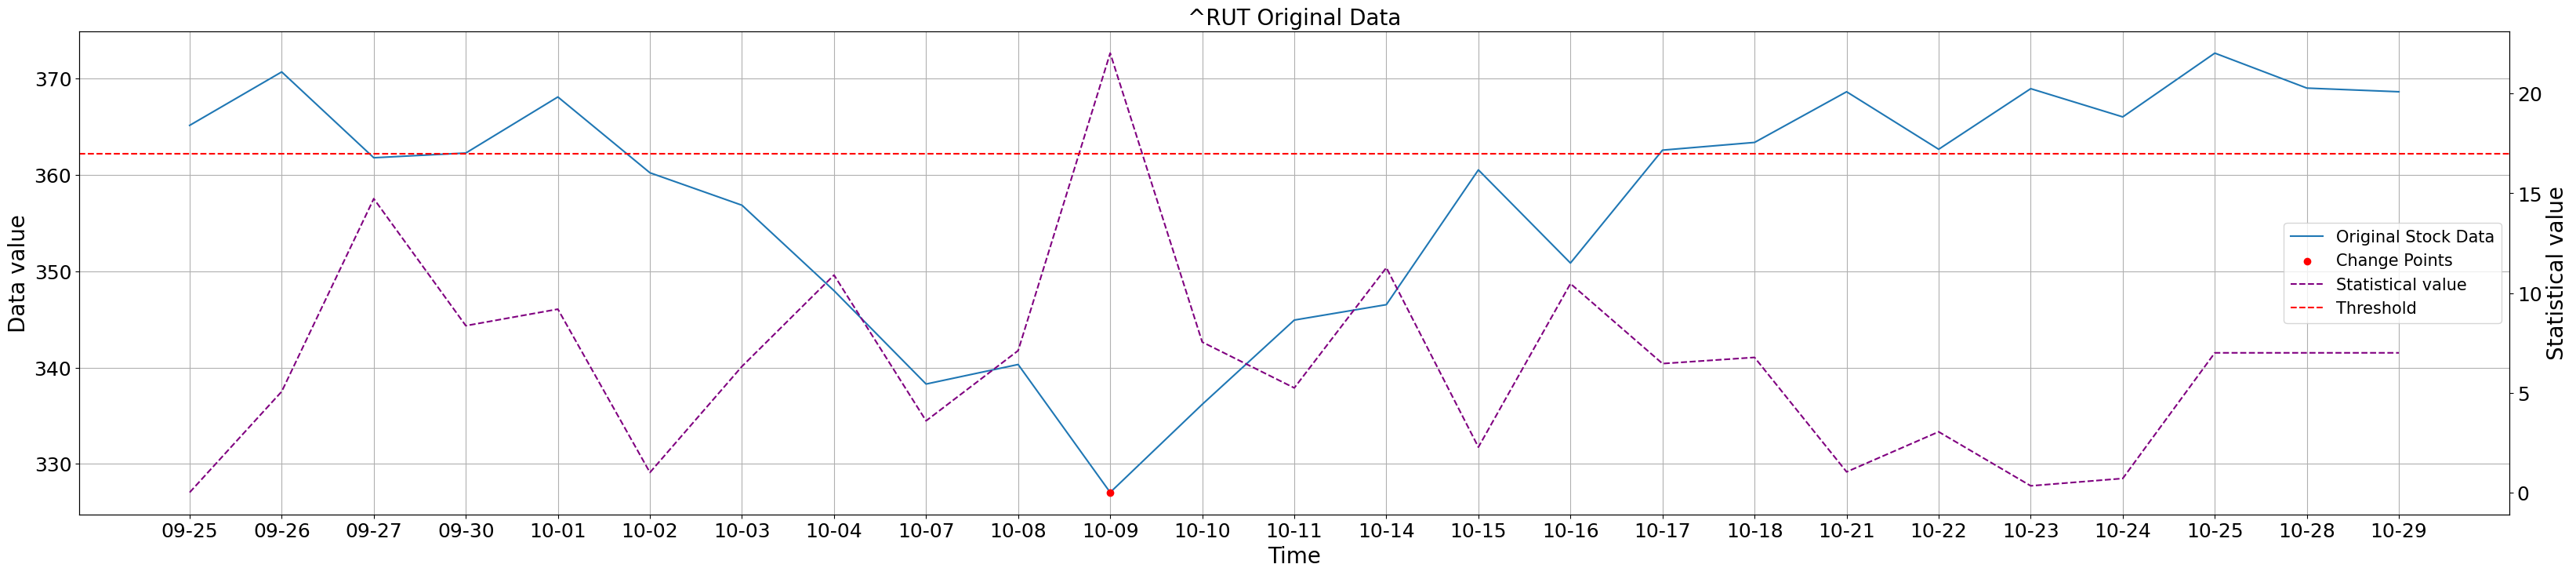

In [200]:
ticker = '^RUT' # Russell 2000 Index
start_date = '2002-09-25'
end_date = '2002-10-30'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 5
threshold = 17
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=slope_change)

# (3) 27-Feb-07

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


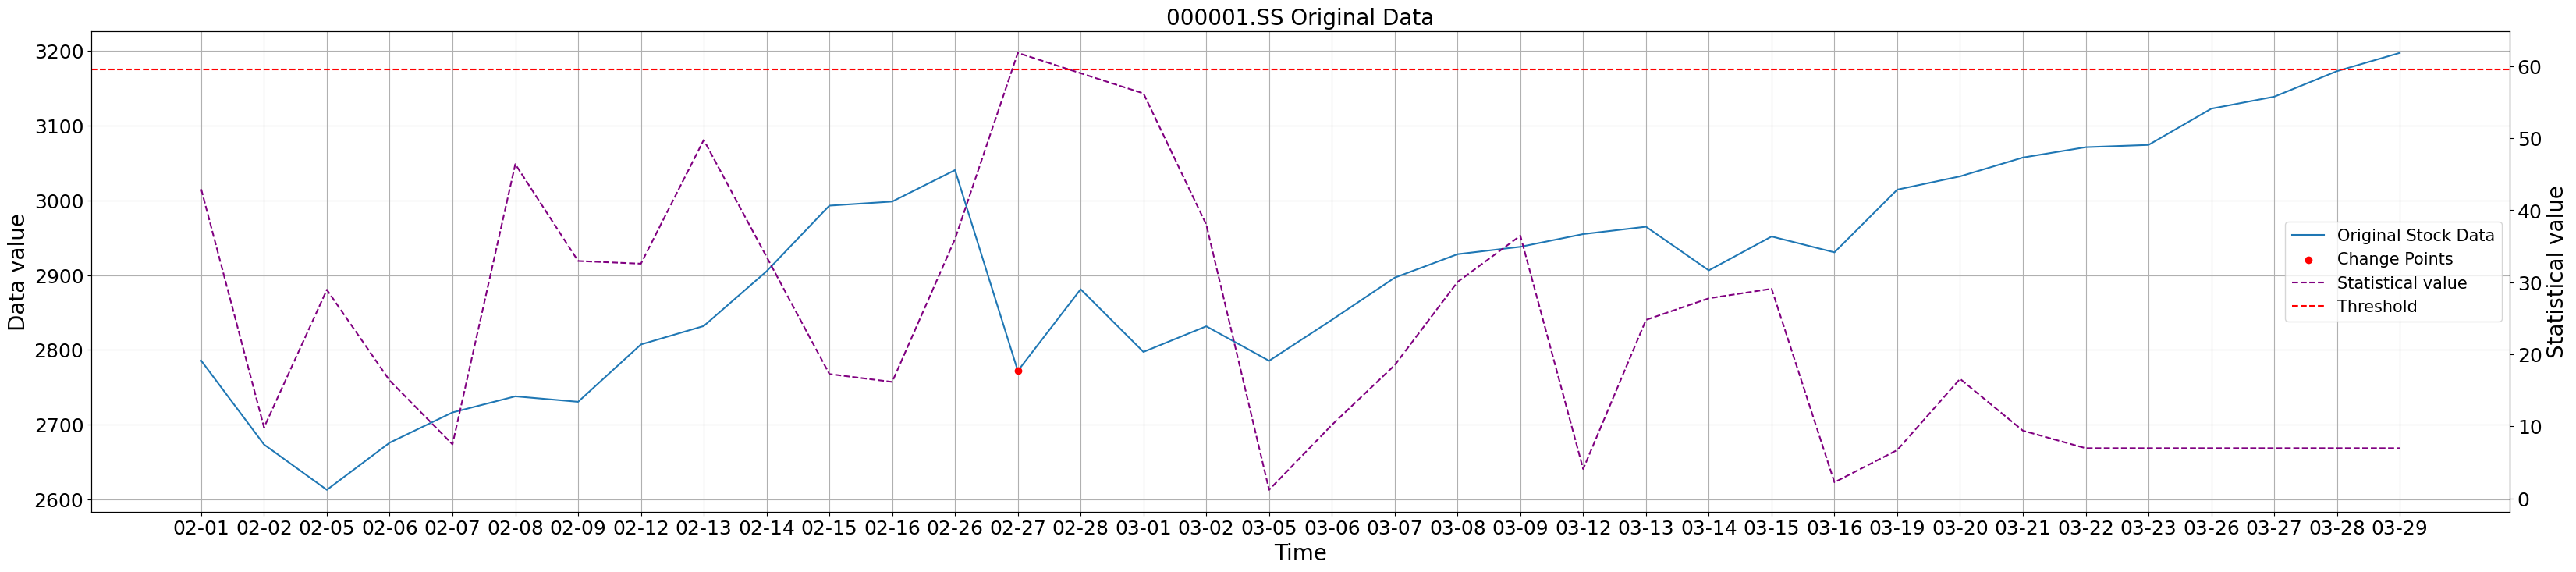

In [738]:
ticker = '000001.SS' # SSE Composite Index
start_date = '2007-02-01'
end_date = '2007-03-30'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 10
threshold= 59.5
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=std_deviation_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/2186366242.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


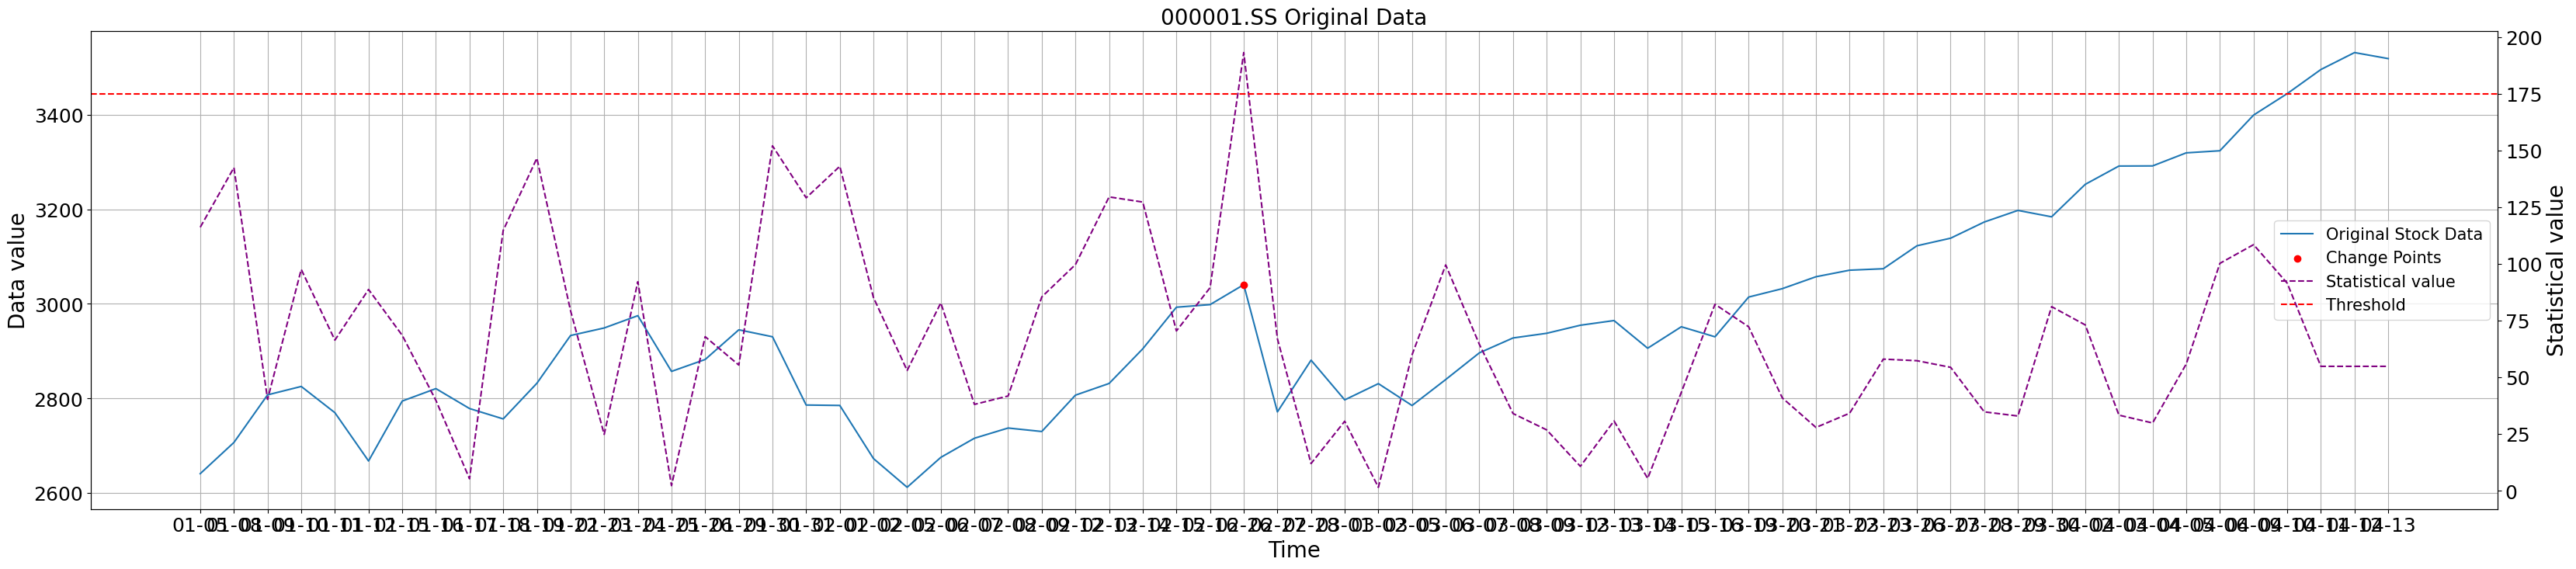

In [209]:
ticker = '000001.SS' # SSE Composite Index
start_date = '2007-01-05'
end_date = '2007-04-15'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 5
threshold= 175
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=mean_shift)

# (4) 11-Oct-07

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


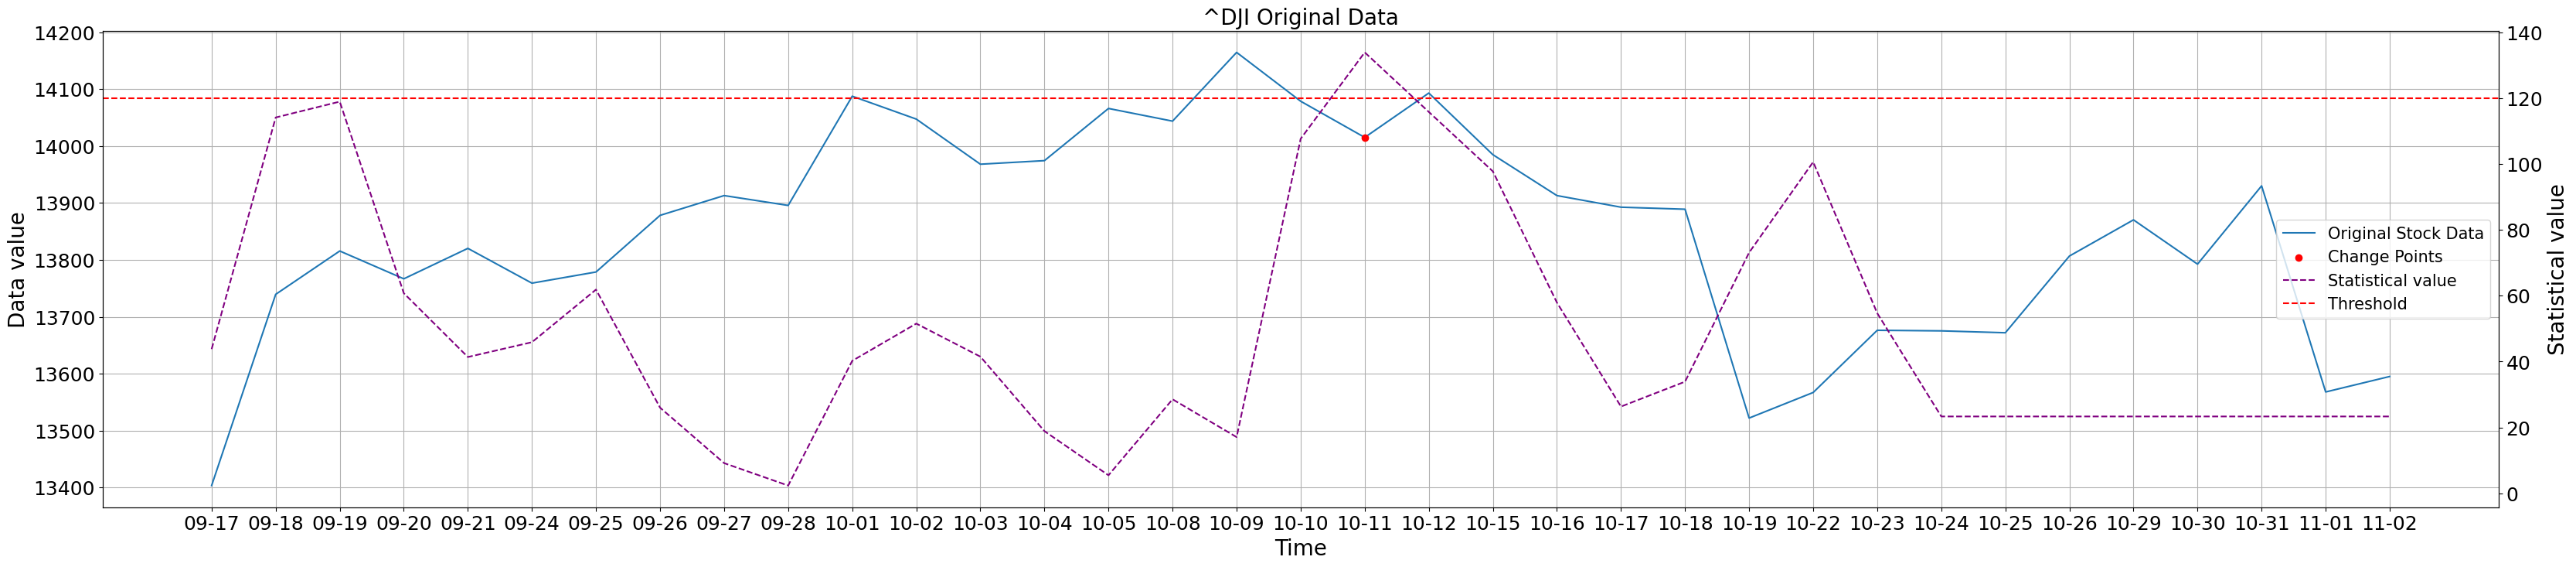

In [701]:
ticker = '^DJI'
start_date = '2007-09-15'
end_date = '2007-11-05' # 10/11

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 15
threshold= 120
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=std_deviation_change)

[*********************100%***********************]  1 of 1 completed


DatetimeIndex(['2007-10-09'], dtype='datetime64[ns]', name='Date', freq=None)


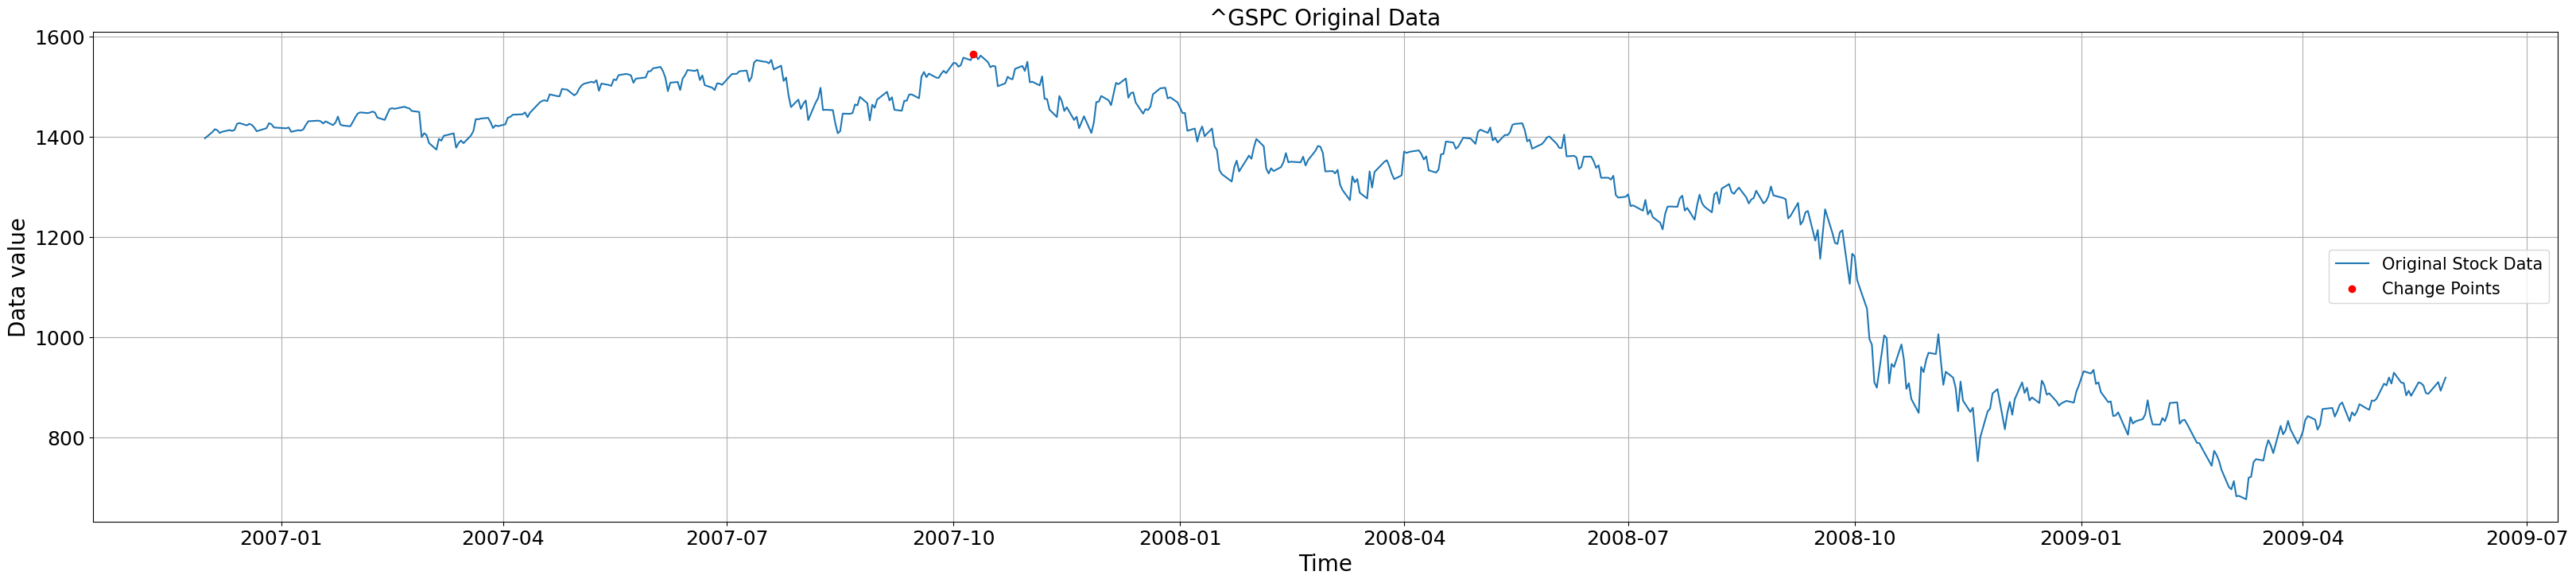

In [345]:
ticker = '^GSPC'
start_date = '2006-12-01'
end_date = '2009-05-31'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

plt.figure(figsize=(40, 8))
ax1 = plt.gca()  # Main axis for original series
# ax2 = ax1.twinx()  # Secondary axis for change points

value = stock_data[stock_data >= 1565].index

# Plot original series
ax1.plot(stock_data, label="Original Stock Data")
ax1.scatter(value, stock_data[value], color='red', label="Change Points", zorder=5)
print(value)

# Titles and labels
title = f"{ticker} Original Data"
ax1.set_title(title, fontsize=20)  # Increase title fontsize
ax1.set_xlabel("Time", fontsize=20)  # Increase label fontsize
ax1.set_ylabel("Data value", fontsize=20)  # Increase label fontsize

# # Increase tick label size
ax1.tick_params(axis='both', which='major', labelsize=18)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc='center right', fontsize=15)  # Combine legends

ax1.grid()
plt.show()

# (5) 16-Sep-08

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


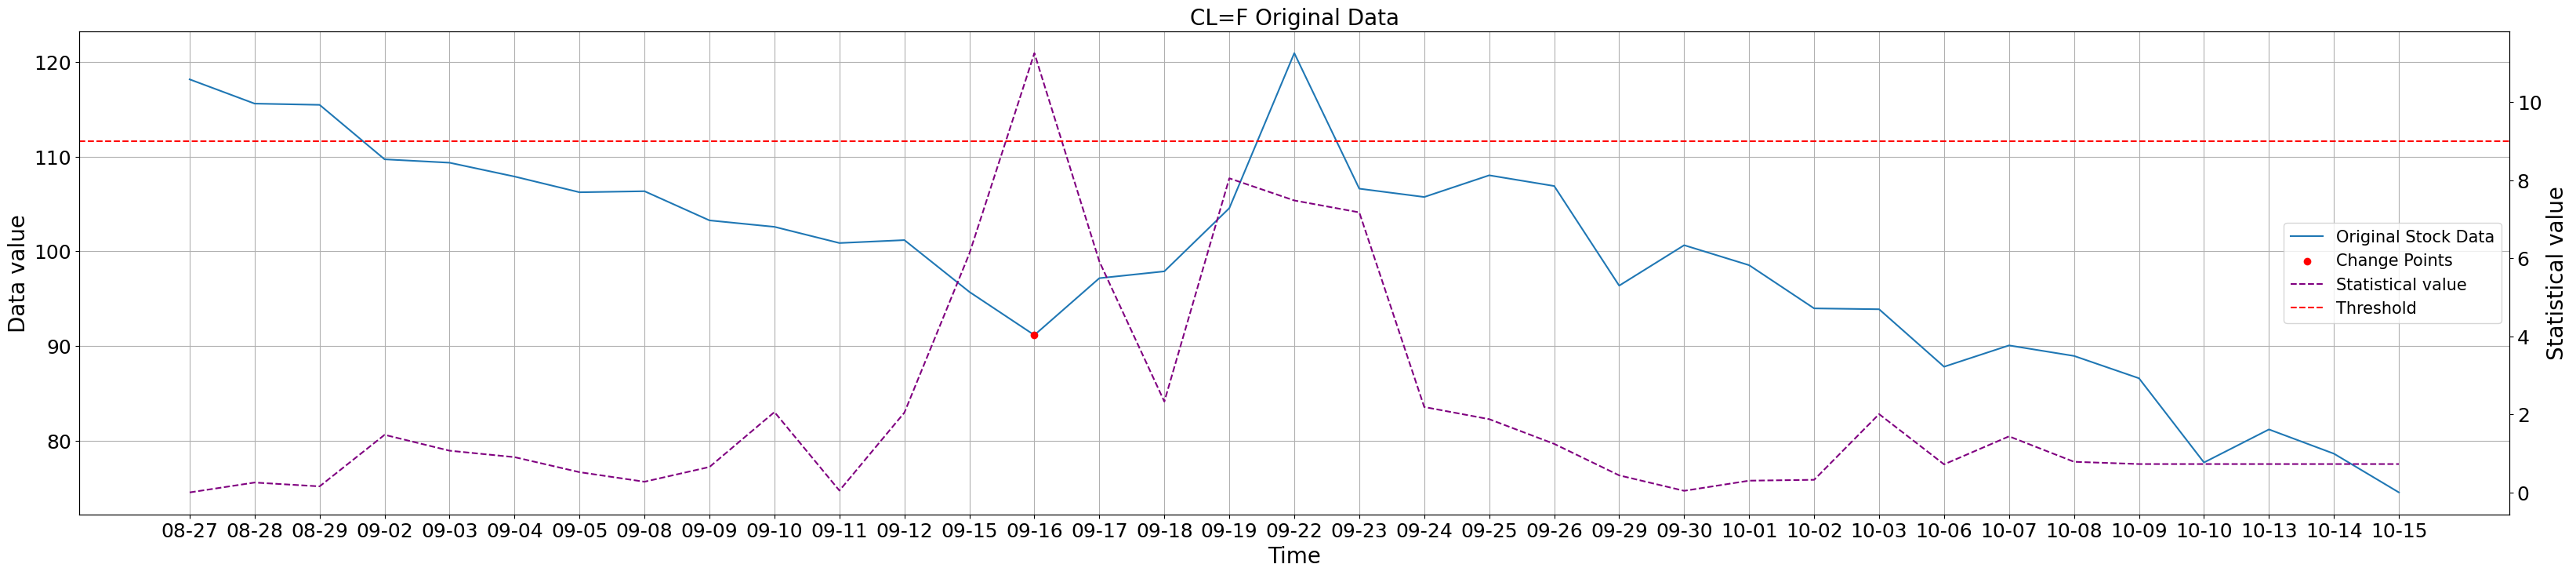

In [386]:
ticker = 'CL=F'
start_date = '2008-08-27'
end_date = '2008-10-16'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 9
threshold= 9
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=slope_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


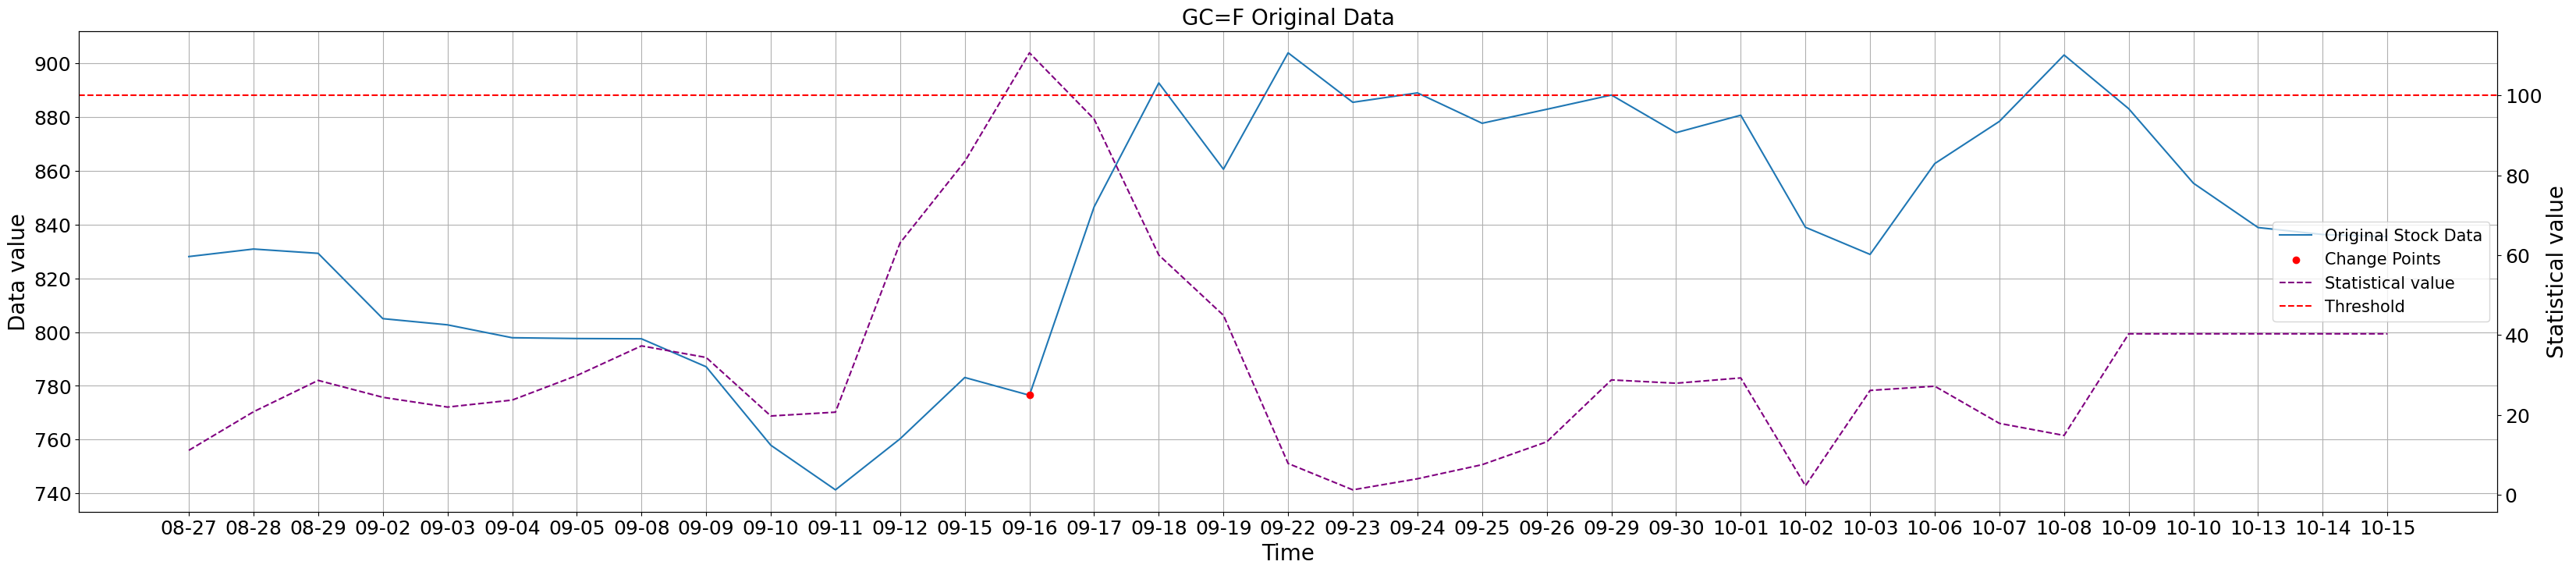

In [398]:
ticker = 'GC=F'
start_date = '2008-08-27'
end_date = '2008-10-16'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 8
threshold= 100
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=mean_shift)

# (6) 27-Nov-09

In [446]:
ticker = 'EEM'
start_date = '2009-11-01'
end_date = '2009-12-30'

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


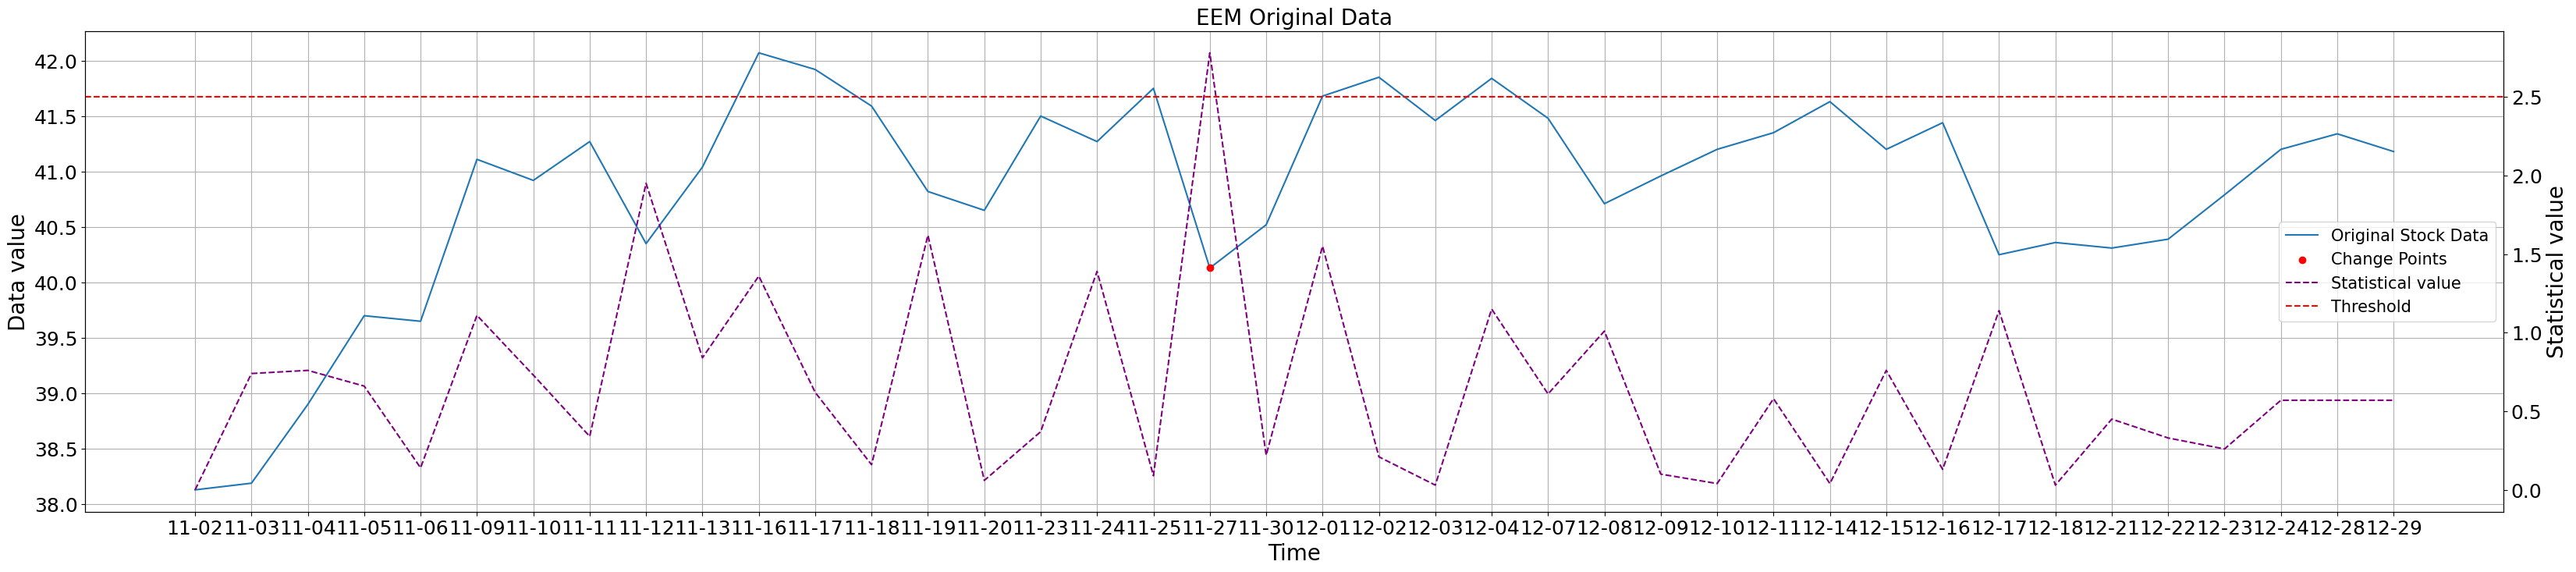

In [452]:
stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 5
threshold= 2.5
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=slope_change)

# (7) 27-Apr-10

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


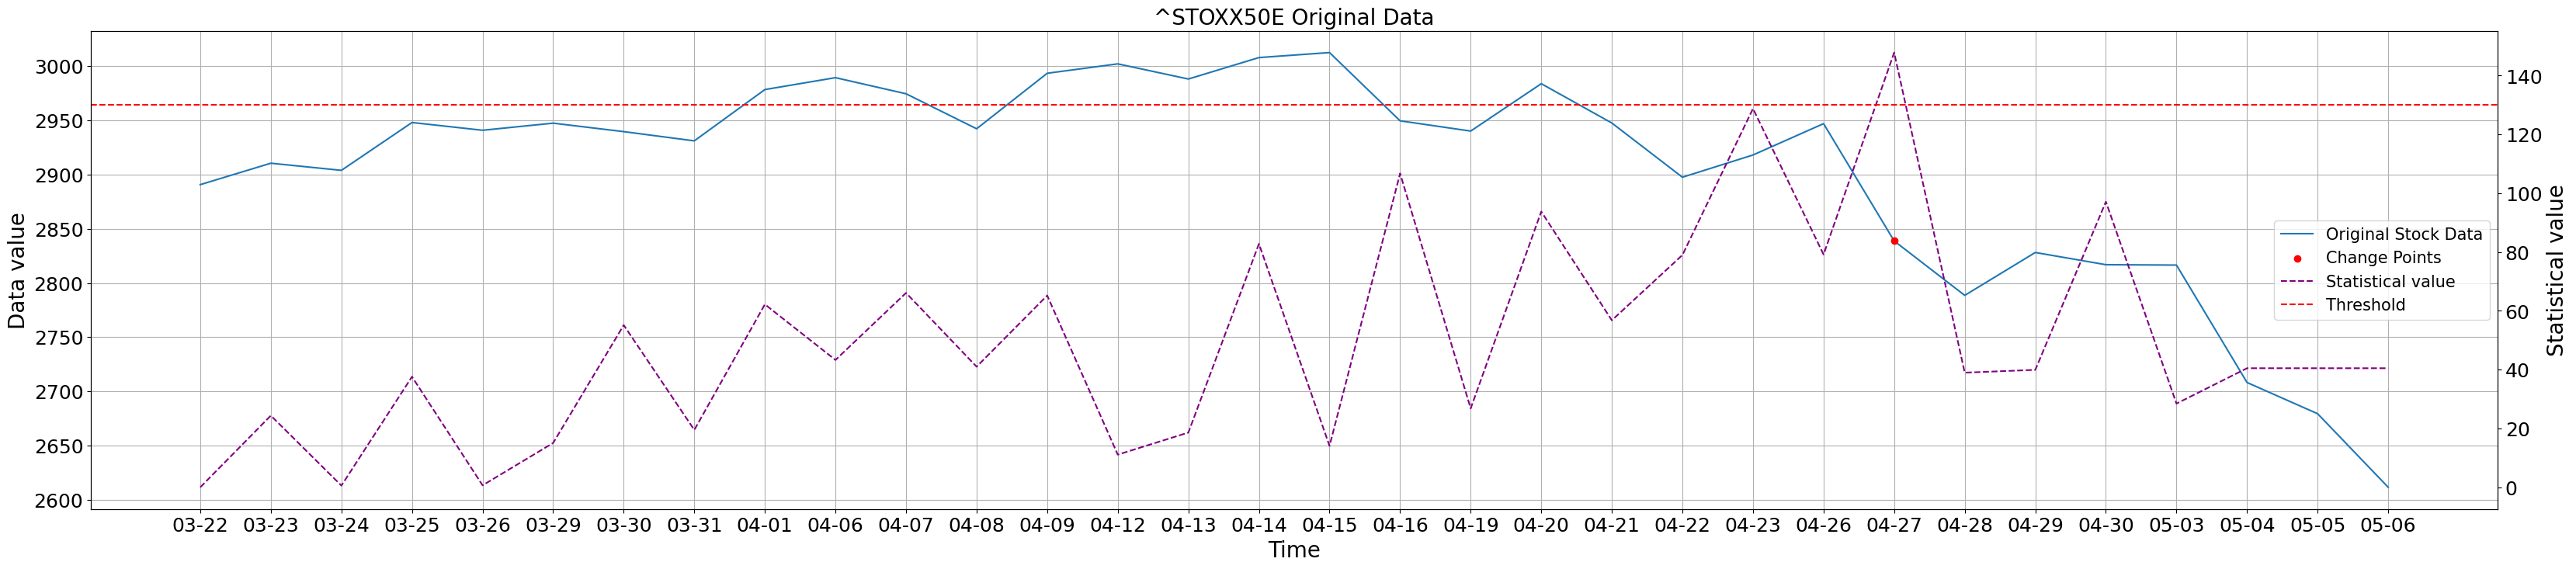

In [478]:
ticker = '^STOXX50E'
start_date = '2010-03-20'
end_date = '2010-05-07'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 5
threshold= 130
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=slope_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


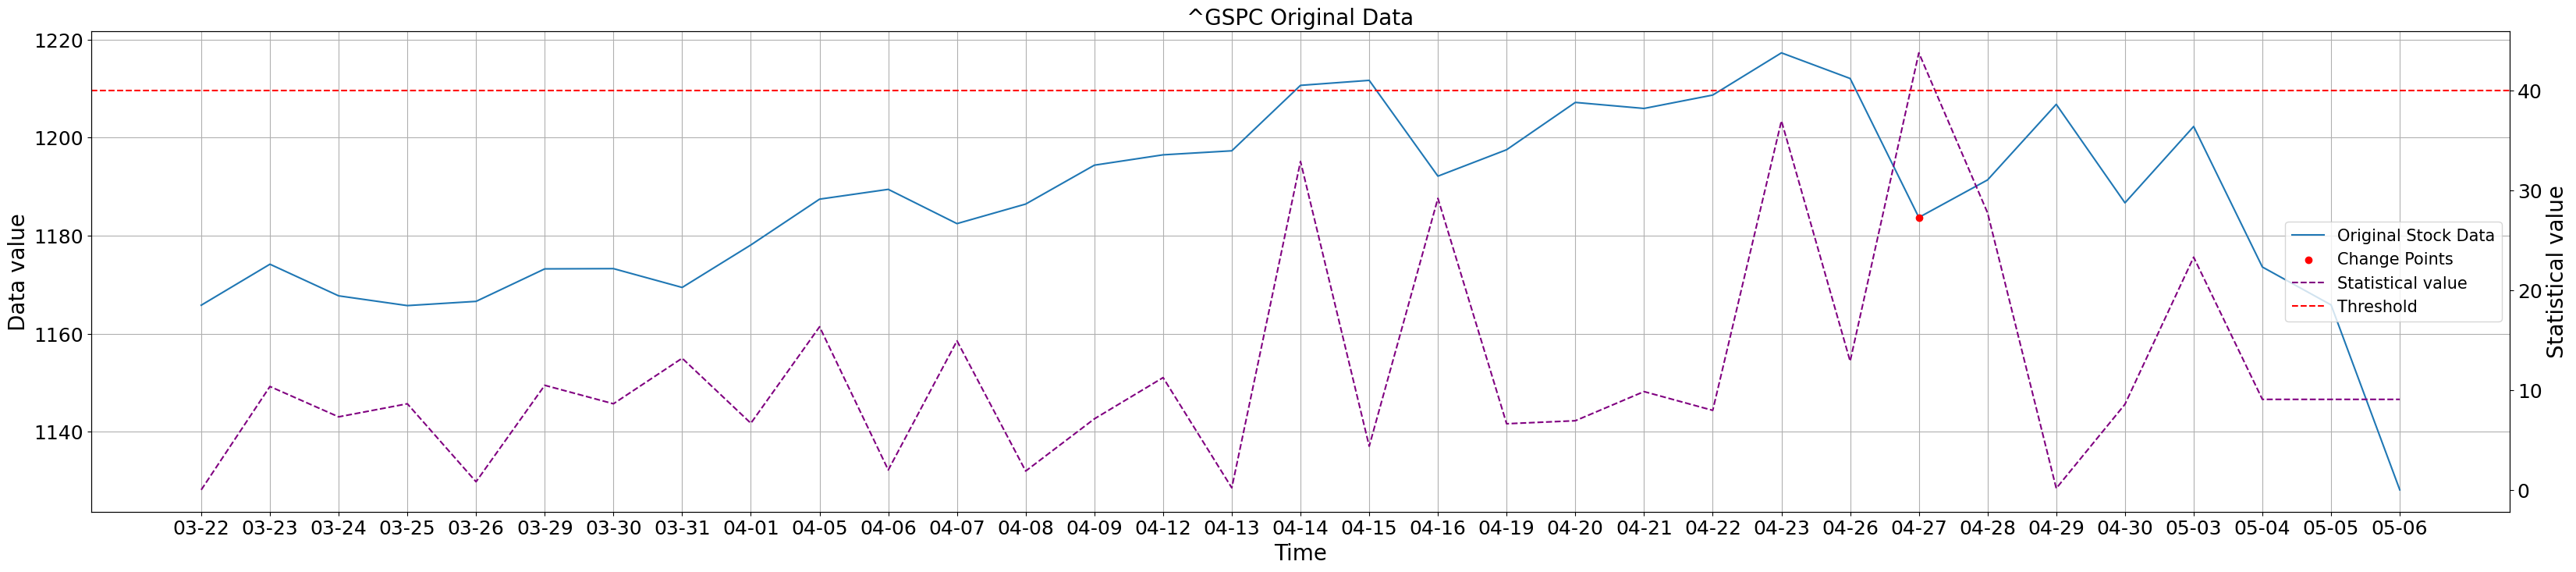

In [482]:
ticker = '^GSPC'
start_date = '2010-03-20'
end_date = '2010-05-07'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 5
threshold= 40
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=slope_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


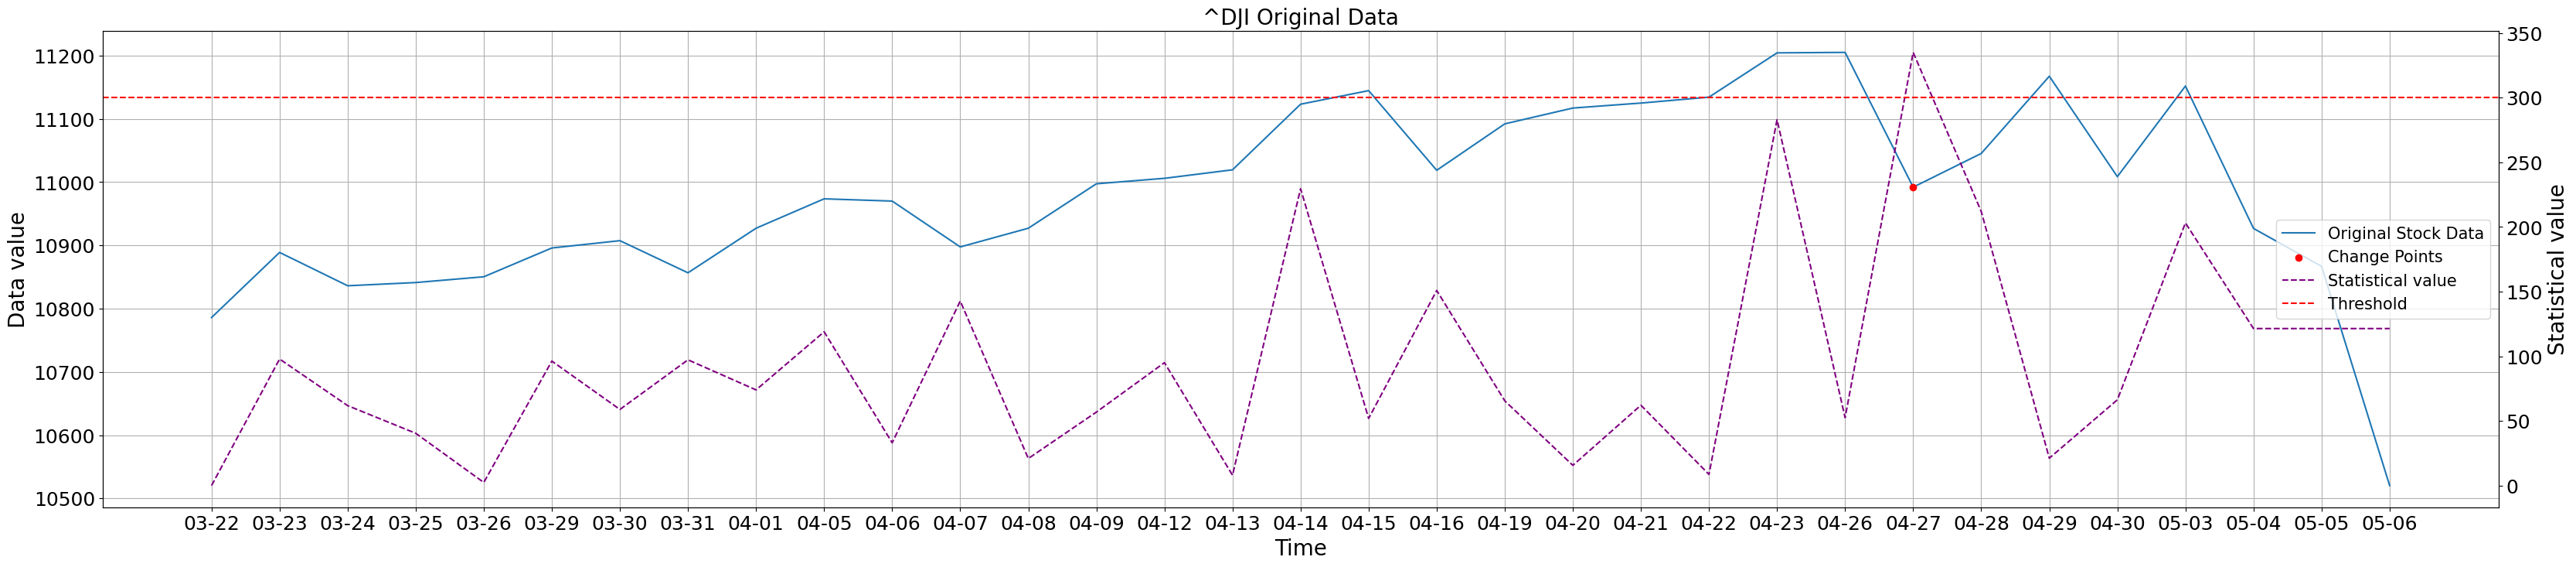

In [484]:
ticker = '^DJI'
start_date = '2010-03-20'
end_date = '2010-05-07'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 5
threshold= 300
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=slope_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


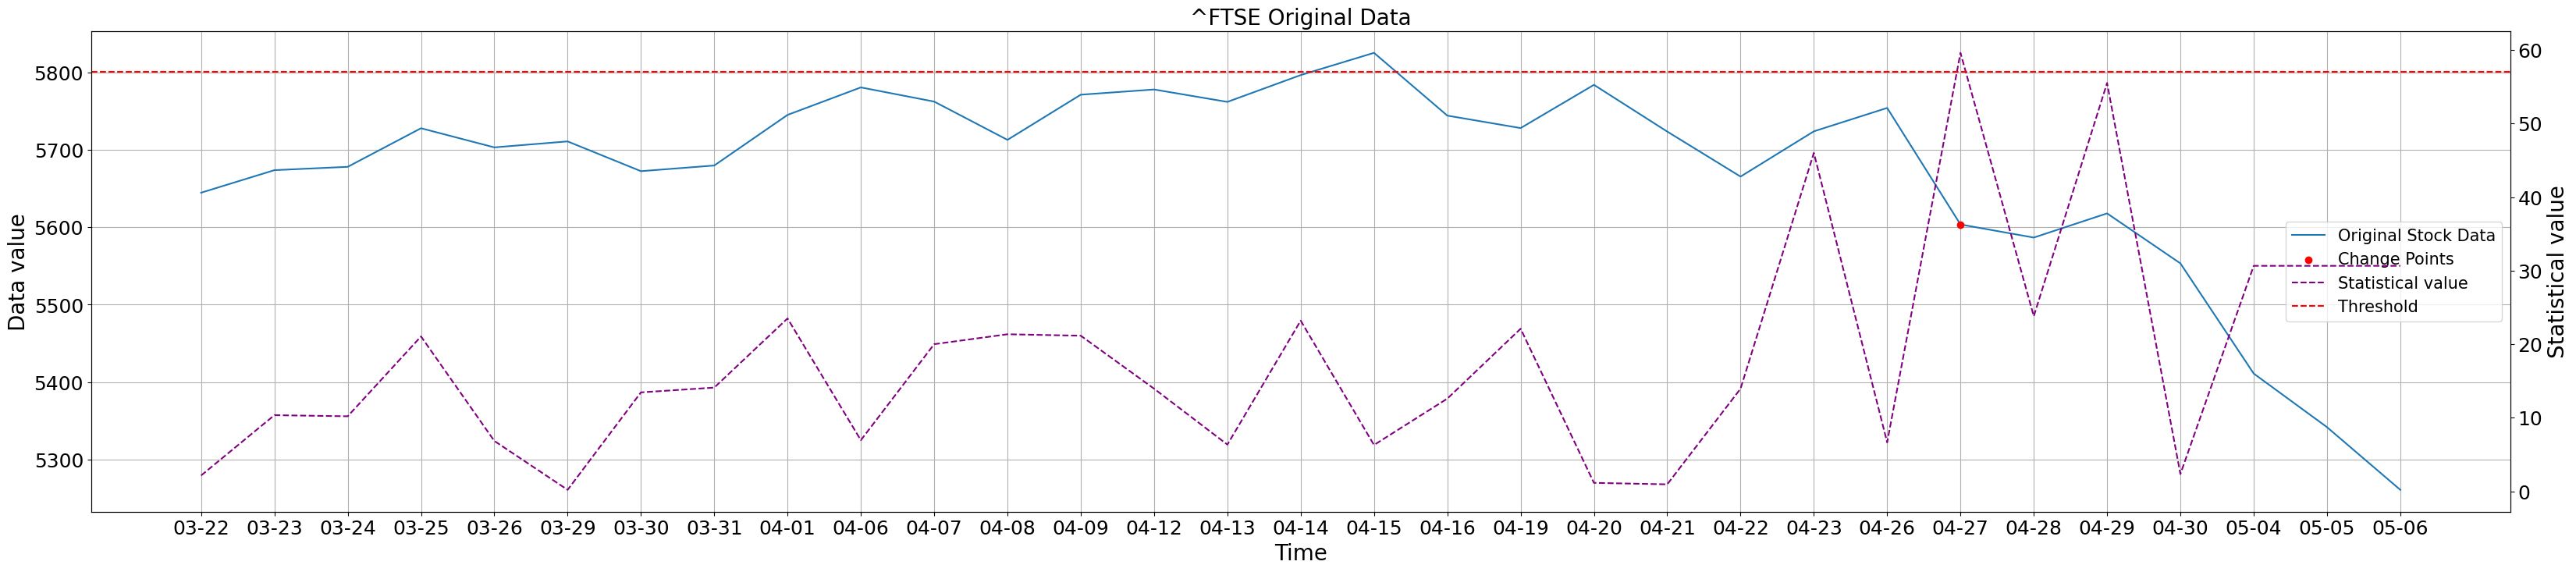

In [505]:
ticker = '^FTSE'
start_date = '2010-03-20'
end_date = '2010-05-07'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 5
threshold= 57
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=std_deviation_change)

# (8) 06-May-10

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


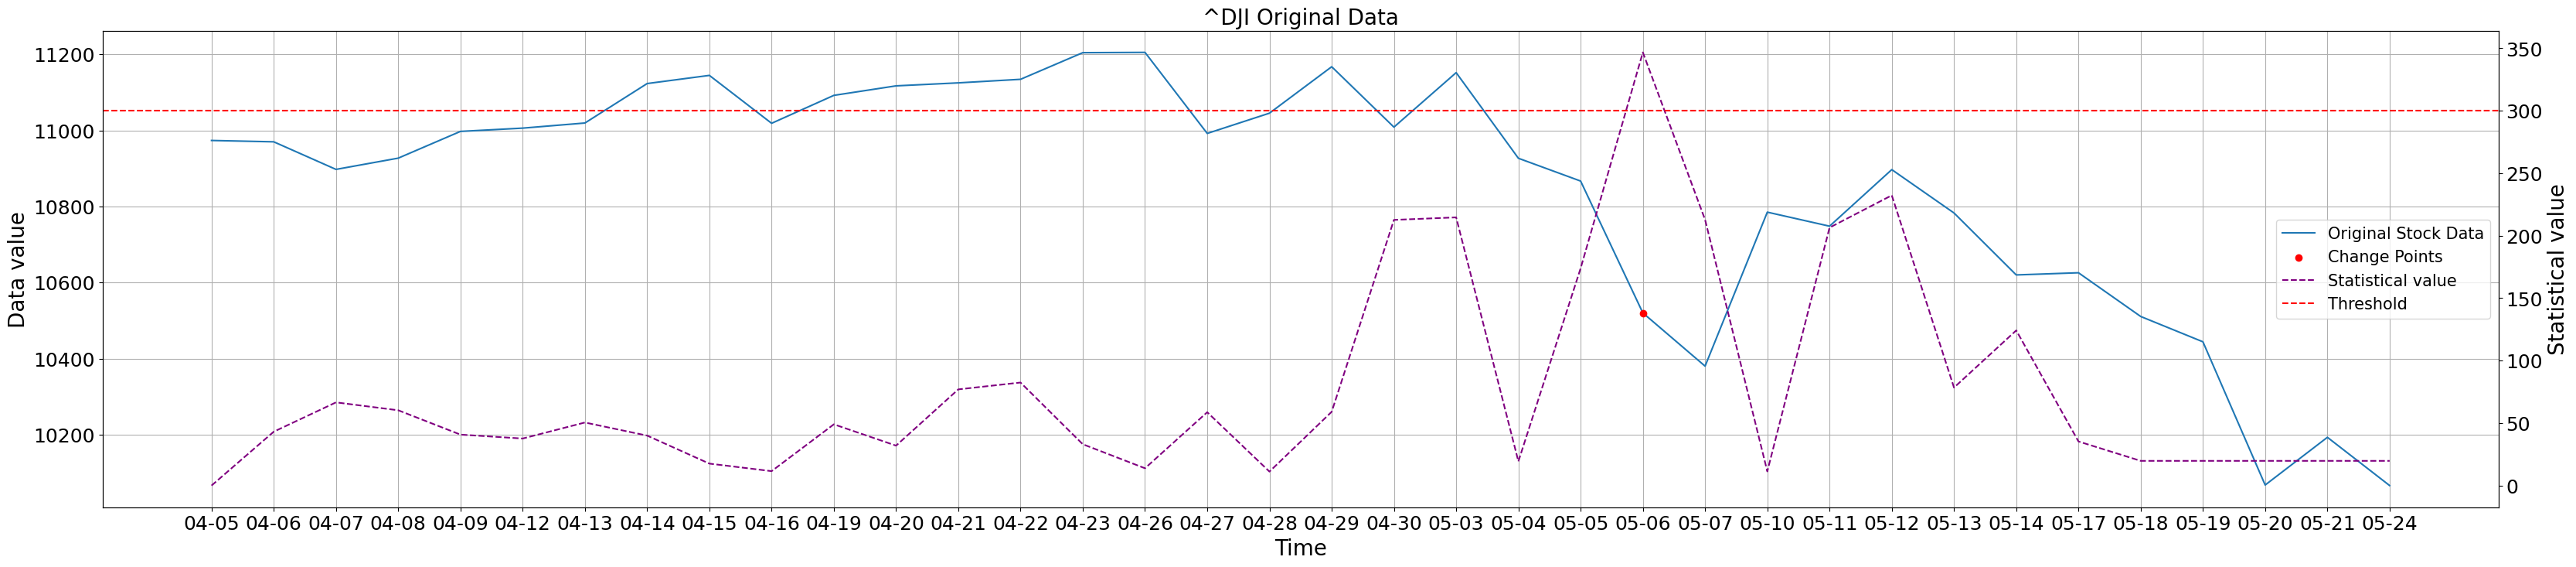

In [527]:
ticker = '^DJI'
start_date = '2010-04-03'
end_date = '2010-05-25'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 8
threshold= 300
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=slope_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


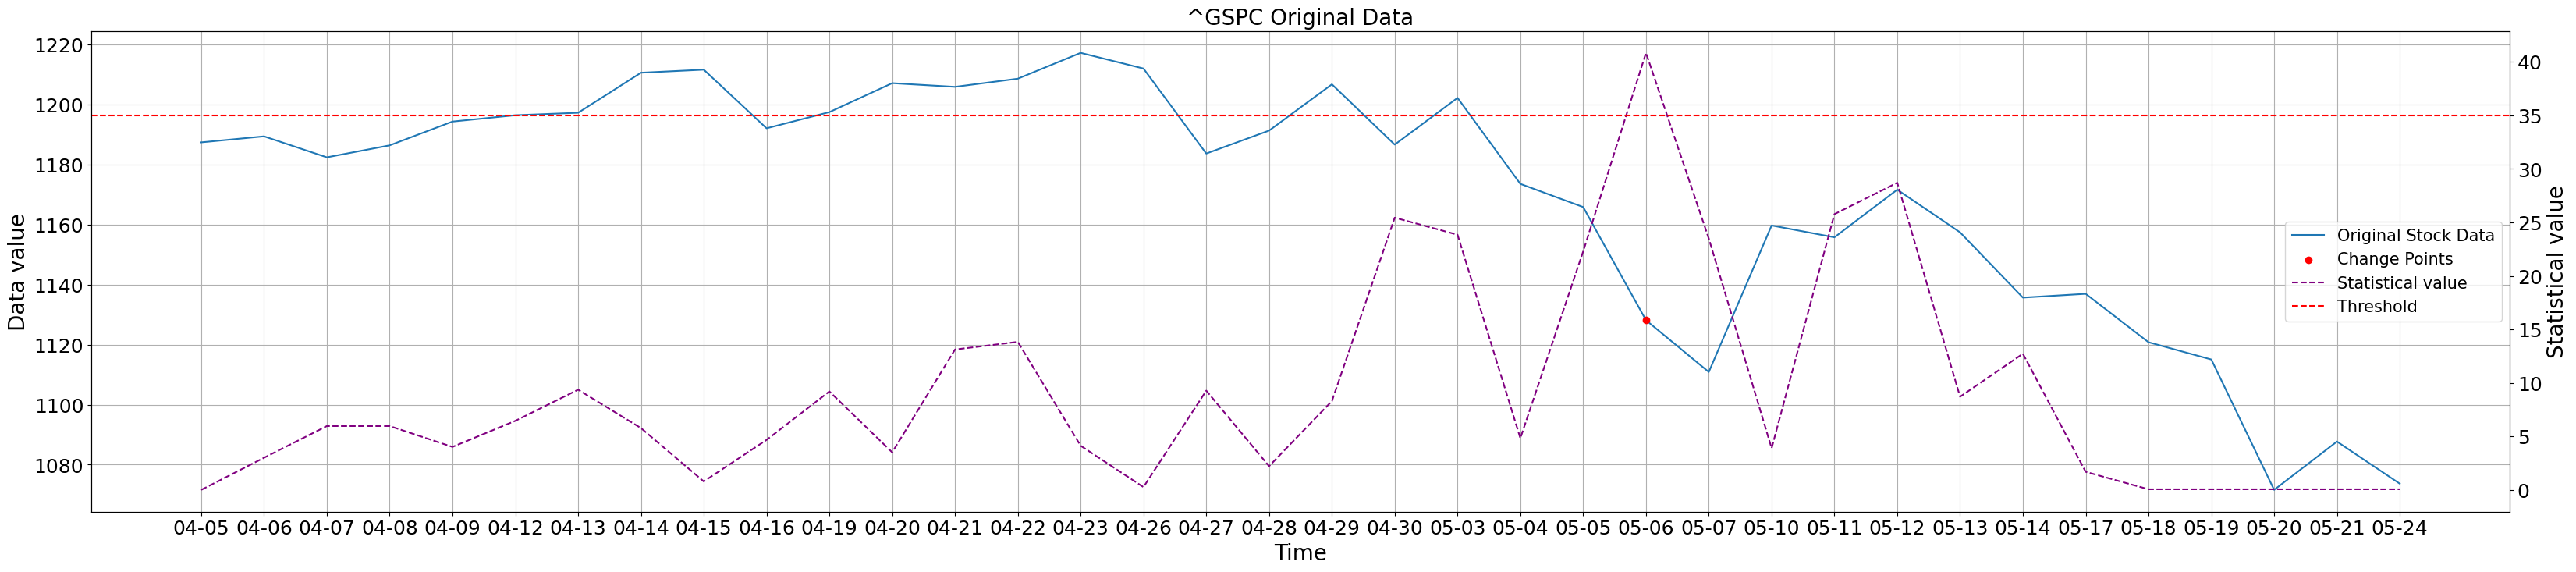

In [530]:
ticker = '^GSPC'
start_date = '2010-04-03'
end_date = '2010-05-25'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 8
threshold= 35
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=slope_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


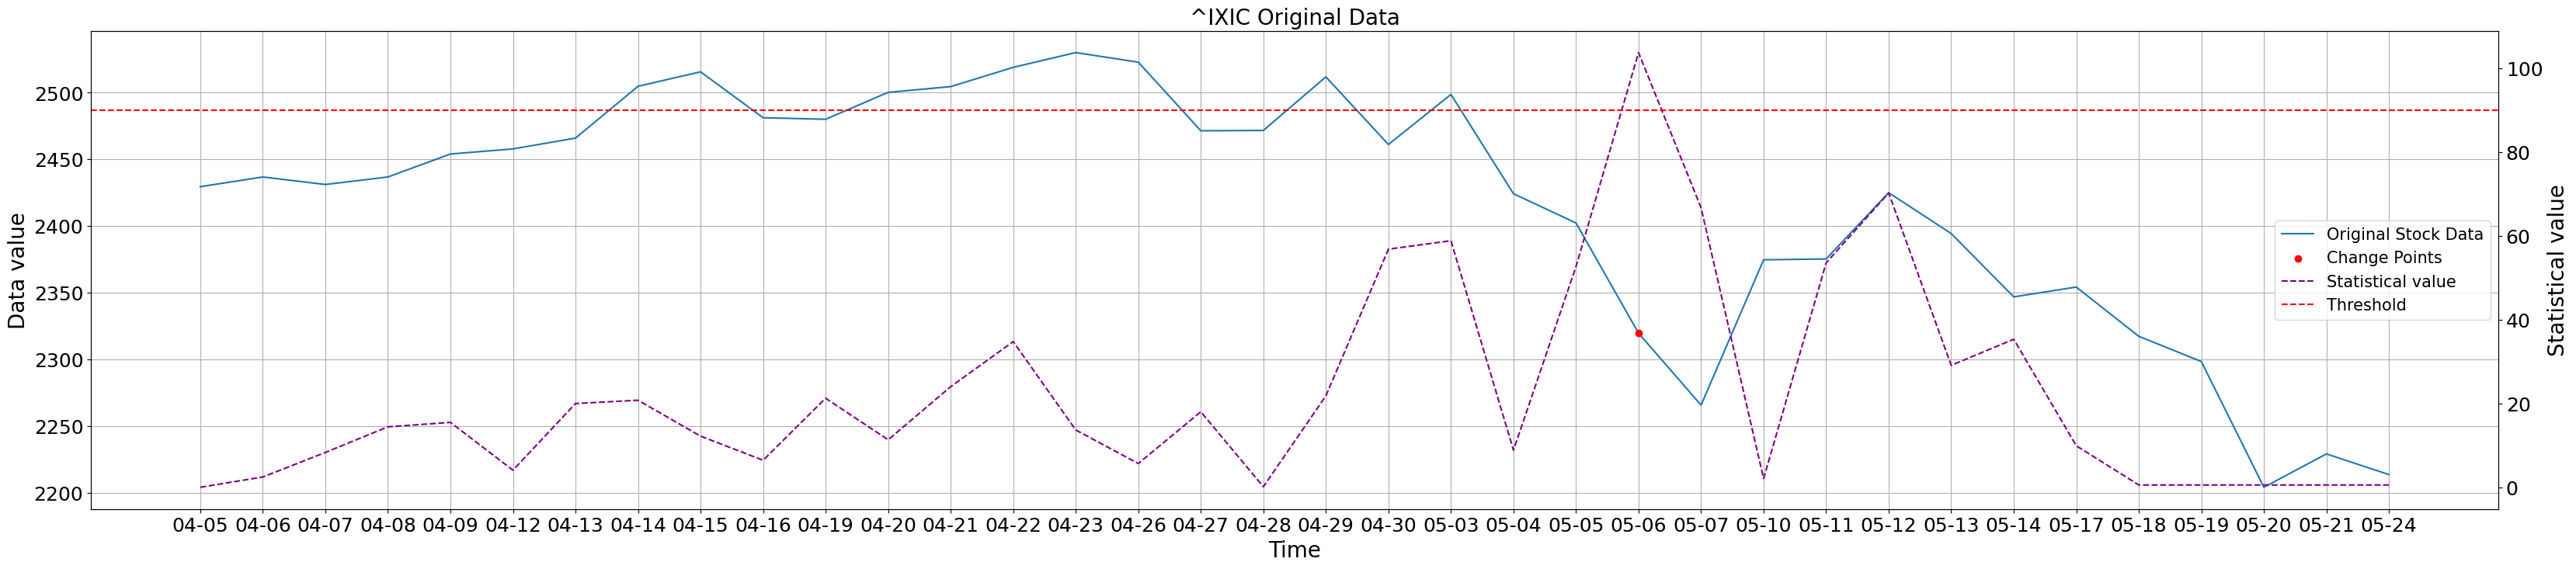

In [532]:
ticker = '^IXIC'
start_date = '2010-04-03'
end_date = '2010-05-25'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 8
threshold= 90
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=slope_change)

# (9) 01-Aug-11

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


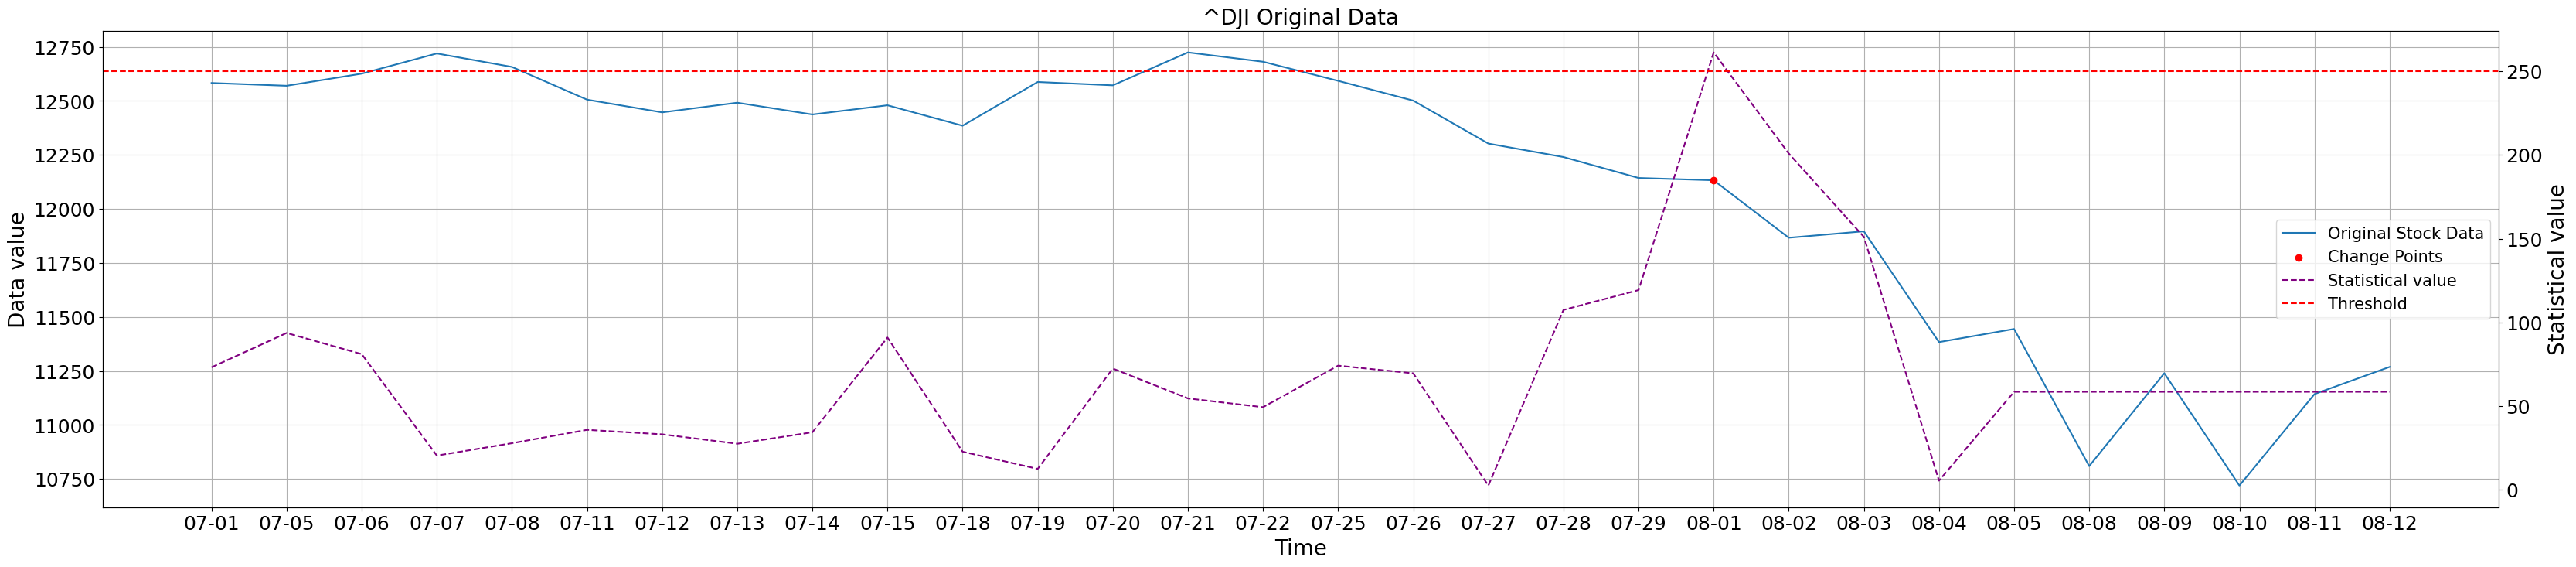

In [549]:
ticker = '^DJI'
start_date = '2011-07-01'
end_date = '2011-08-14'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 10
threshold= 250
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=std_deviation_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


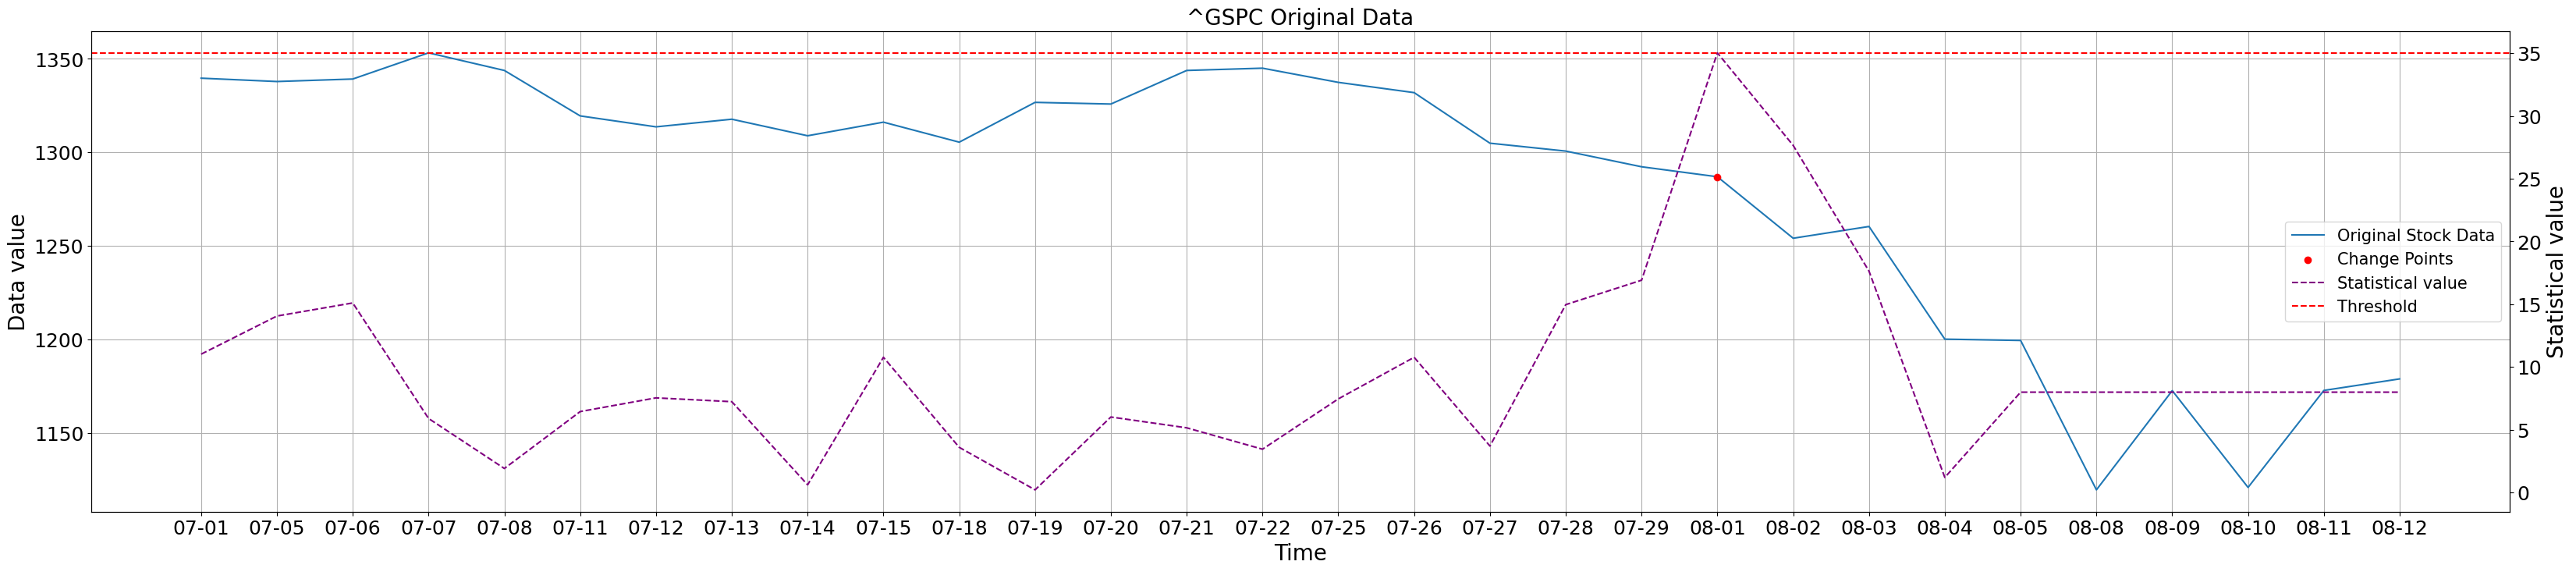

In [551]:
ticker = '^GSPC'
start_date = '2011-07-01'
end_date = '2011-08-14'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 10
threshold= 35
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=std_deviation_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


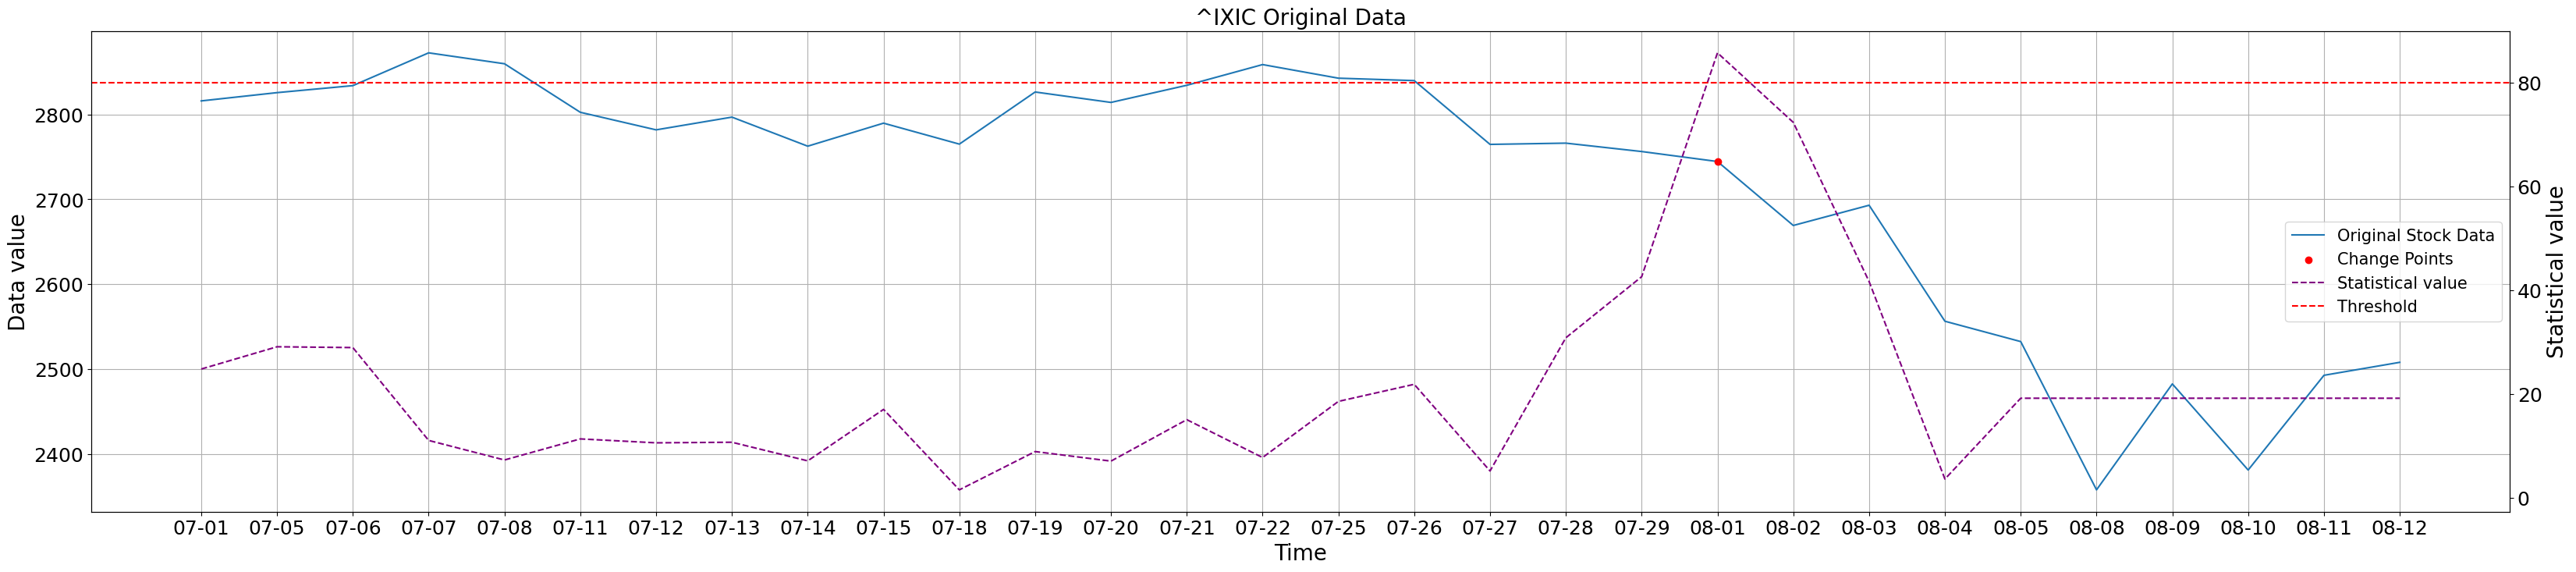

In [553]:
ticker = '^IXIC'
start_date = '2011-07-01'
end_date = '2011-08-14'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 10
threshold= 80
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=std_deviation_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


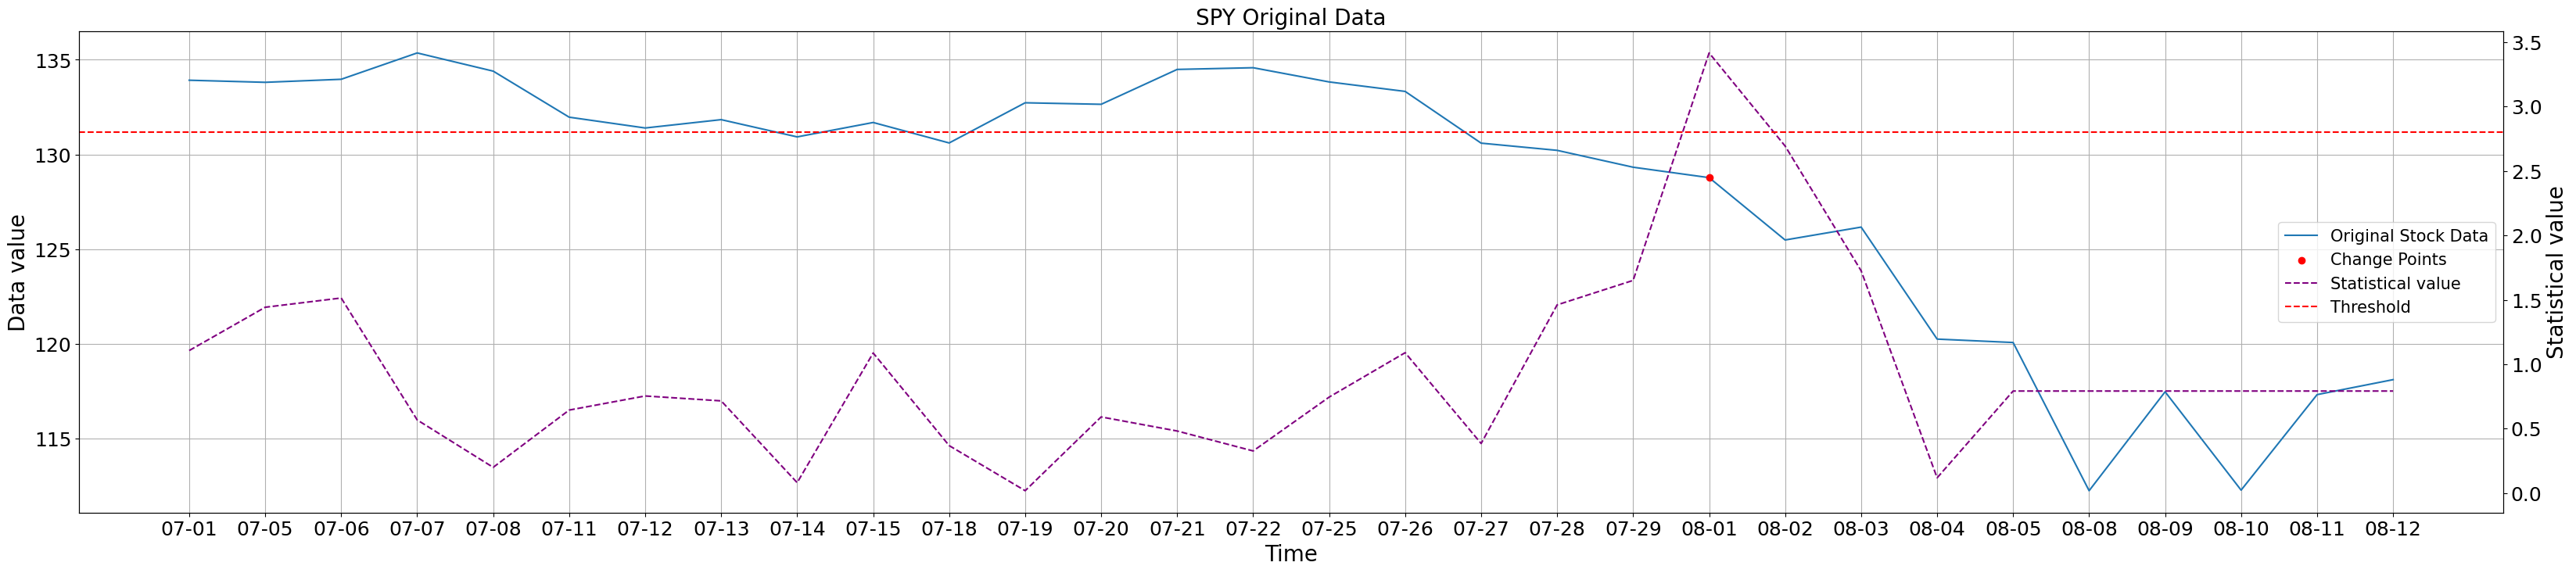

In [556]:
ticker = 'SPY'
start_date = '2011-07-01'
end_date = '2011-08-14'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 10
threshold= 2.8
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=std_deviation_change)

# (10) 12-Jun-15

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


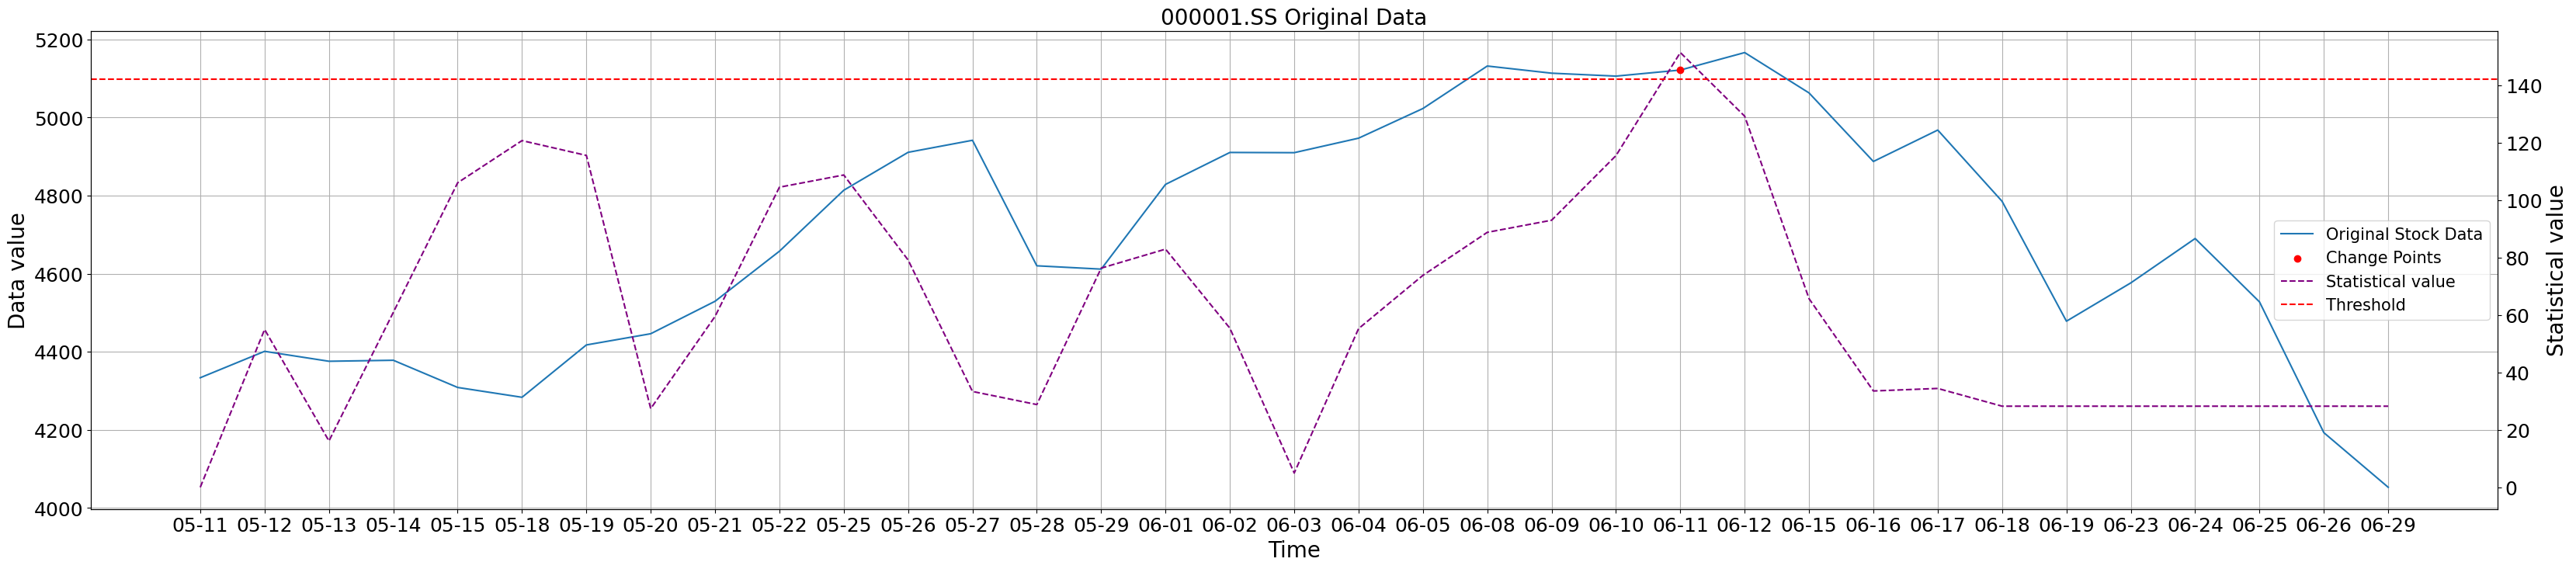

In [586]:
ticker = '000001.SS'
start_date = '2015-05-10'
end_date = '2015-06-30'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 13
threshold= 142
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=slope_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


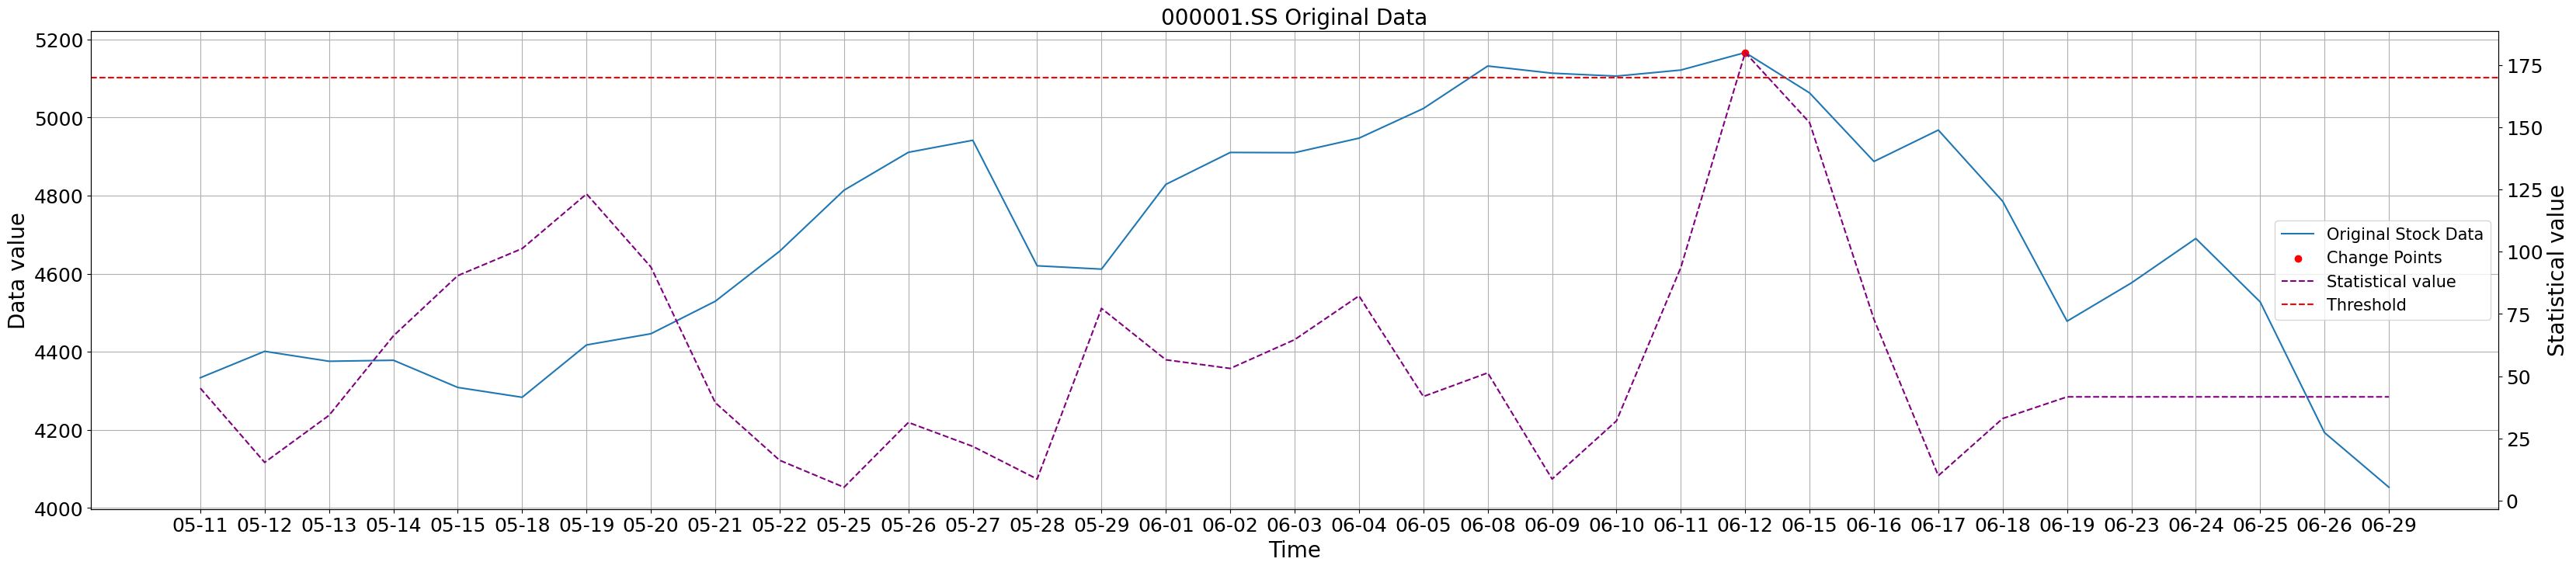

In [585]:
ticker = '000001.SS'
start_date = '2015-05-10'
end_date = '2015-06-30'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 10
threshold= 170
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=std_deviation_change)

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


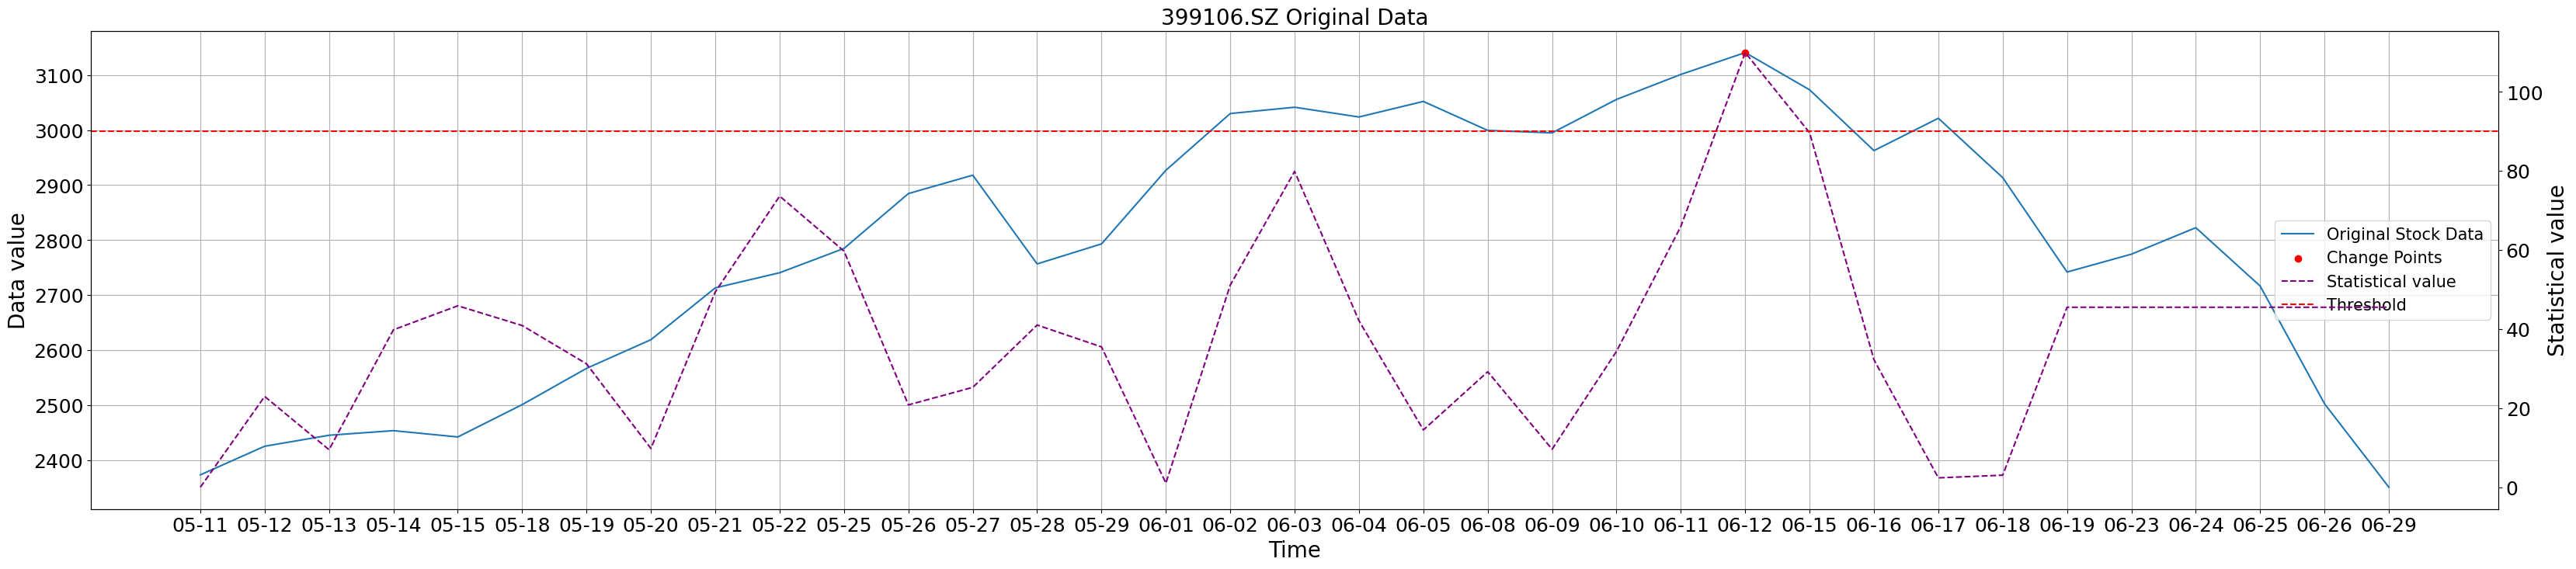

In [601]:
ticker = '399106.SZ'
start_date = '2015-05-10'
end_date = '2015-06-30'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 10
threshold= 90
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=slope_change)

# (11) 18-Aug-15

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


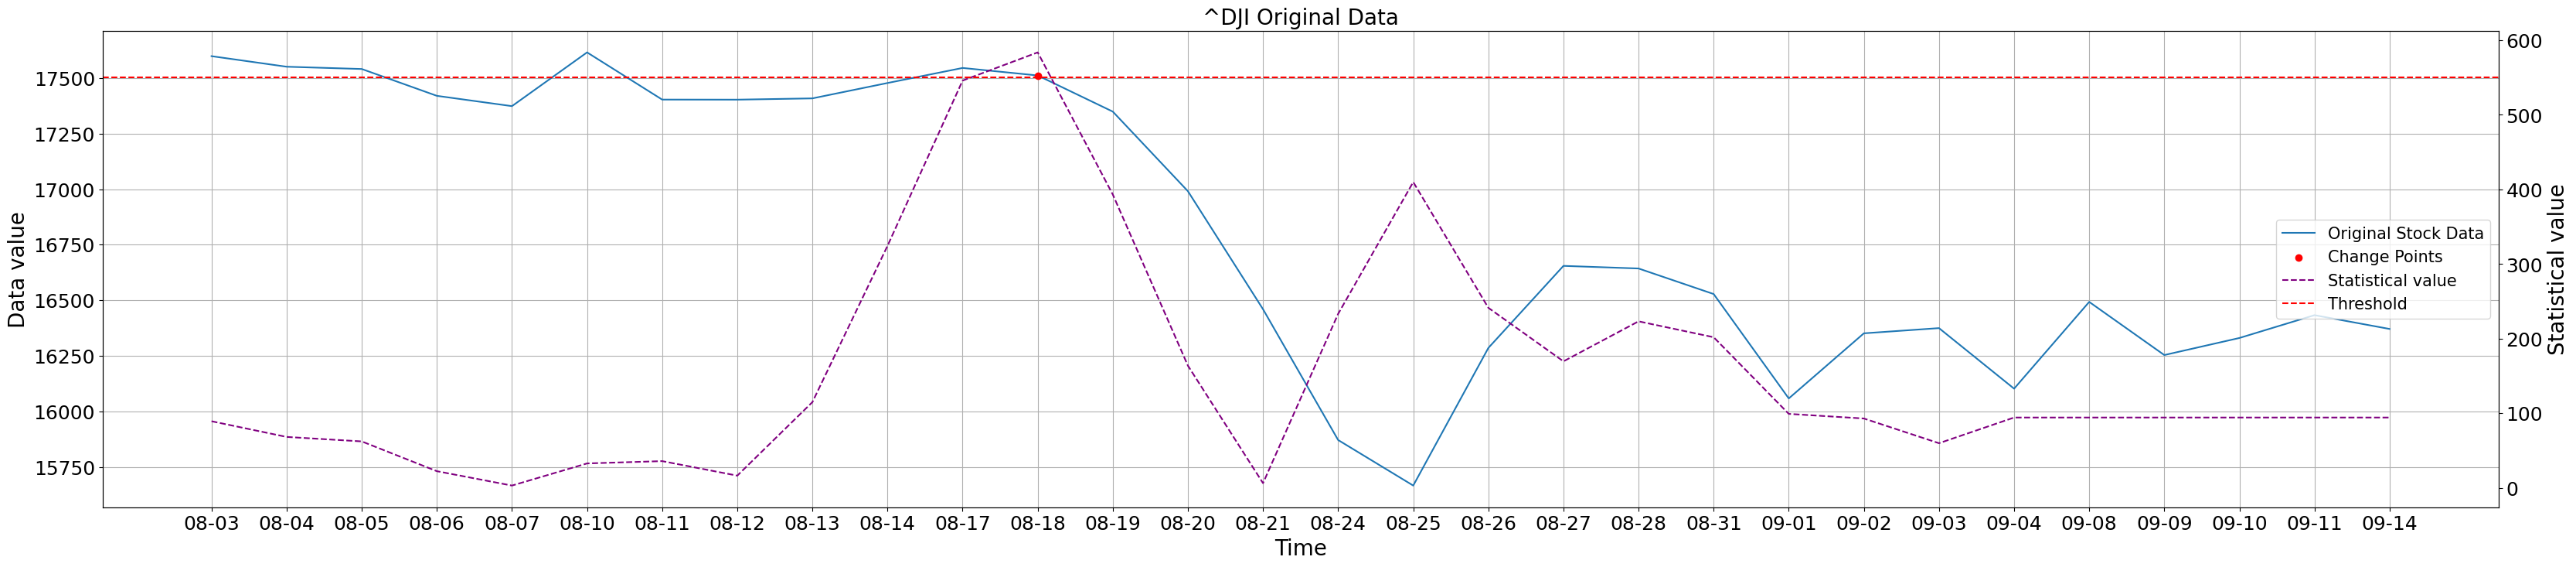

In [636]:
ticker = '^DJI'
start_date = '2015-08-01'
end_date = '2015-09-15'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 10
threshold= 550
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=std_deviation_change)

# (12) 24-Feb, 2020

[*********************100%***********************]  1 of 1 completed
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_40532/571852952.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return differences.fillna(method="ffill").fillna(0).values


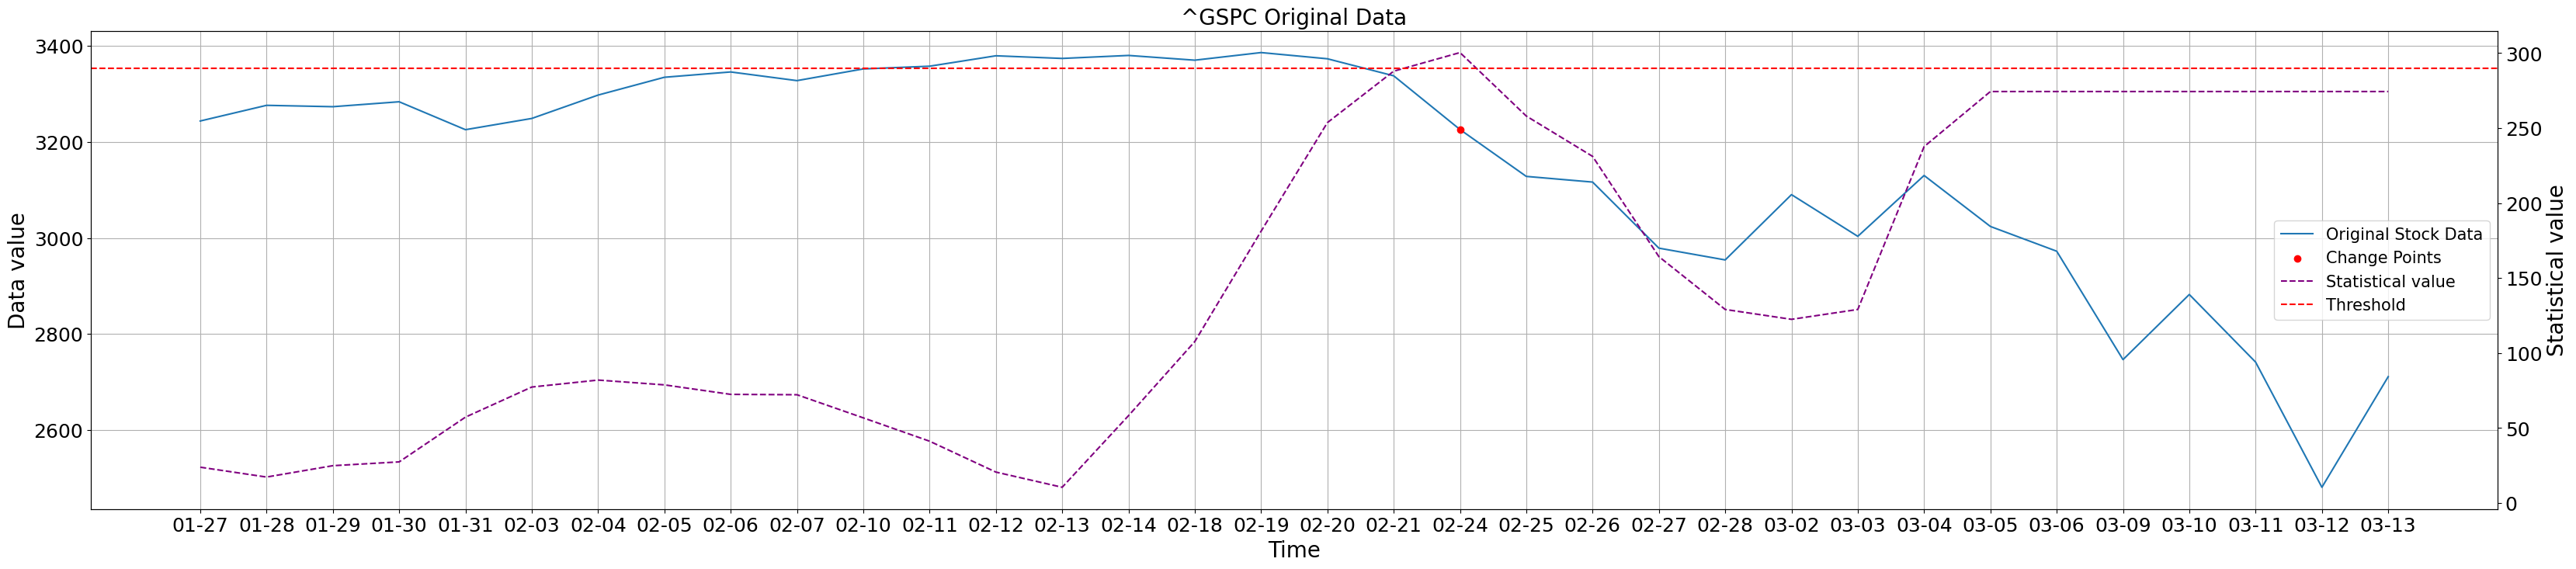

In [666]:
ticker = '^GSPC'
start_date = '2020-01-27'
end_date = '2020-03-15'

stock_data = download_stock_data(ticker, start_date, end_date)
stock_data = preprocess_stock_data(stock_data)

window_size = 13
threshold= 290
# 원본 데이터
plot_change_points_original(stock_data = stock_data, title = f"{ticker} Original Data", threshold=threshold, window_size=window_size,  matrix=mean_shift)